In [1]:
cd ~/code/jwstmc/

/home/lnie/code/jwstmc


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.wcs import WCS
import os
import time
import webbpsf
nrca_short_filters = ['F070W', 'F090W', 'F115W', 'F140M', 'F150W2', 'F150W', 'F162M', 'F164N', 'F182M', 'F187N',
                          'F200W', 'F210M', 'F212N']
nrca_long_filters = ['F250M', 'F277W', 'F300M', 'F322W2', 'F323N', 'F335M', 'F356W', 'F360M', 'F405N', 'F410M',
                         'F430M', 'F444W', 'F460M', 'F466N', 'F470N', 'F480M']

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})

**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


In [3]:
dirs="/data/JWST_rev/"
Cam="NIRCam/"
filtes=["F277W","F356W","F444W"]
cat_header=["#   1 NUMBER                 Running object number\n",                                  
"#   2 X_IMAGE                Object position along x                                      [pixel]\n",
"#   3 Y_IMAGE                Object position along y                                      [pixel]\n",
"#   4 FWHM_IMAGE             FWHM assuming a gaussian core                                [pixel]\n",
"#   5 FLUX_RADIUS            Fraction-of-light radii                                      [pixel]\n",
"#   6 FLUX_AUTO              Flux within a Kron-like elliptical aperture                  [count]\n",
"#   7 FLUXERR_AUTO           RMS error for AUTO flux                                      [count]\n",
"#   8 FLAGS                  Extraction flags                                                    \n"                                          
"#   9 CLASS_STAR             S/G classifier output\n"]

#defination useful functions
def get_filename(file_dir,append):
    fname=[];
    for list in os.listdir(file_dir):
        if os.path.isfile(os.path.join(file_dir,list)):
            if list[(len(list)-len(append)):len(list)]==append:
                fname.append(list);

    return fname
def write_fits(fitsname,data,head1=None,head2=None):
    wdata=data;
    if head1==None :
        #print("head1 none",fitsname)
        hdu = fits.PrimaryHDU(wdata)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head1==None:
        #print("head2 none",fitsname)
        hdu = fits.PrimaryHDU(wdata,header=head1)
        hdul = fits.HDUList([hdu])
        hdul.writeto(fitsname,overwrite=True)
    if head1!=None and head2!=None:
        #print("head1 not none",fitsname)
        hdu = fits.PrimaryHDU(header=head1)
        hdu1= fits.ImageHDU(wdata,header=head2)
        hdul = fits.HDUList([hdu,hdu1])
        hdul.writeto(fitsname,overwrite=True)
def fft_conv(image,psf):
    '''
    convlove image with a psf,usually image size should be larger than psf
    '''
    size=image.shape
    core=np.zeros(size,dtype='float')
    nx=image.shape[0];ny=image.shape[1]
    px=psf.shape[0];py=psf.shape[1]
    ra=int((nx-px)/2);rb=int((ny-py)/2)
    core[ra-1:ra+px-1,rb-1:rb+py-1]=psf
    Fg=np.fft.fft2(image)
    Fp=np.fft.fft2(core)
    Fg*=Fp
    for i in range(Fp.real.shape[0]):
        for j in range(Fp.real.shape[1]):
            l=(i+j+2)%2
            if (l==1) :Fg.real[i][j]*=-1;Fg.imag[i][j]*=-1;
    tmp=np.fft.ifft2(Fg)
    cimage=tmp.real
    return(cimage)

def pixel2wcs(header,px,py):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([px-CRPIX1,py-CRPIX2])
    Mt=np.matmul(MCD,Mp)
    Mwcs=np.array([CRVAL1,CRVAL2])
    Mwcs=Mt+Mwcs
    return(Mwcs[0],Mwcs[1])

def wcs2pixel(header,wcsx,wcsy):
    CD1_1   =  header['CD1_1']
    CD1_2   =  header['CD1_2']
    CD2_1   =  header['CD2_1']
    CD2_2   =  header['CD2_2'] 
    CRPIX1  =  header['CRPIX1']
    CRPIX2  =  header['CRPIX2']  
    CRVAL1  =  header['CRVAL1']
    CRVAL2  =  header['CRVAL2'] 
    MCD=np.array([[CD1_1,CD1_2],
                  [CD2_1,CD2_2]])
    Mp=np.array([wcsx-CRVAL1,wcsy-CRVAL2])
    iMCD=np.linalg.inv(MCD)
    Mt=np.matmul(iMCD,Mp)
    Mpos=np.array([CRPIX1,CRPIX2])
    Mpos=Mt+Mpos
    return(Mpos[0],Mpos[1])


In [4]:
#for F356W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/F444Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)
    
def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcalong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F444W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE*9)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel1.fits")
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel.fits")
    comodel=hdu[0].data
except:
    wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            nrc.detector="NRCA5" 
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                w = WCS(hdu0['SCI'].header)
                sky=w.pixel_to_world(spos[ic][0],spos[ic][1]);
                #wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.world_to_pixel(sky)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                '''wcsx,wcsy=pixel2wcs(hdu0['SCI'].header,spos[ic][0],spos[ic][1])
                ipx,ipy=wcs2pixel(hdu['SCI'].header,wcsx,wcsy)
                print(spos[ic][0],spos[ic][1],ipx,ipy)'''
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=Ng0+Nim,oversample=2)
                    wmodel[Tim][ic]=(psf[0].data/np.sum((psf[0].data))).T              
    for ic in range(Nobj):
        for ex in range(9):
            if wmodel[ex][ic].any!=0:
                comodel[ic,:,:]+=wmodel[ex,ic,:,:]
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel.fits",comodel)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
PCs,pos,coeff,getNobj,slecstar,webcoeff,slecwgt,slecimodel=web_psf_fit(
    instar,
    spos,
    npc,
    gain=1.84,
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=40)
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,3)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_mcoshape.cat","w")
fpw=open(stamp_dirs+slicename+"_mcwshape.cat","w")
fpm=open(stamp_dirs+slicename+"_mcmshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=2)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_webchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_mixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_webresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_mixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

        



clean Nobj= 59
(59, 80, 80) (59, 80, 80)
clean Nobj= 59
/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it1_UPDC_rev4_comodel1.fits
osam=2
Ngm 85
59 80 10 1.84 1
start delivery
Nstar=59
Nstar=59
mask
imodel
method iSPCA
gain=1.840000
sum=94359.937676
snr=29.505283
sum=306015.592608
snr=69.087215
sum=61169.123638
snr=12.506444
sum=187165.241140
snr=38.064796
sum=67414.595154
snr=11.608794
sum=383334.283604
snr=104.676921
sum=483246.450044
snr=113.425906
sum=46400.672385
snr=12.426015
sum=1459109.248089
snr=257.522258
sum=291772.791325
snr=66.529179
sum=1499507.409480
snr=389.740233
sum=604059.133949
snr=144.895159
sum=206301.504927
snr=54.841832
sum=225733.826166
snr=50.965986
sum=95378.993725
snr=22.084392
sum=206516.634834
snr=45.689054
sum=99337.404759
snr=26.468805
sum=399556.396676
snr=103.712021
sum=600051.125750
snr=158.387008
sum=1568725.058252
snr=284.268990
sum=3940006.990188
snr=948.492944
sum=54281.205342
snr=16.179186
sum=2358211.831402
snr=528.39098

14.225263165104312 13.795434998129414
(152, 152) 30 -0.704565001870586 -0.27473683489568756 2
(170, 170) 30 -0.704565001870586 -0.27473683489568756 2
(152, 152) 30 -0.704565001870586 -0.27473683489568756 2
1.0558532518477706 0.9738056349998355
-1.4023843564985424e-02 0.004743876063182677 6.314571027729076
-0.008422067348871505 0.0016309157028903693 6.4446428382376375
11 -2.2873029290547944 49.33223888766102
14.333753829270634 13.666246170729366
(152, 152) 30 -0.8337538292706341 -0.16624617072936587 2
(170, 170) 30 -0.8337538292706341 -0.16624617072936587 2
(152, 152) 30 -0.8337538292706341 -0.16624617072936587 2
0.9226837965028885 0.964240718161631
1.371461070426101e-02 -0.005545606483210631 6.497757984218877
0.015443732235251494 -0.006050117849071039 6.633559384485656
12 4.1333524016528065 72.94102365315149
13.9275815 14.5
(152, 152) 30 0.0 -0.5724184999999995 2
(170, 170) 30 0.0 -0.5724184999999995 2
(152, 152) 30 0.0 -0.5724184999999995 2
0.9583657532856895 0.9646668106768646
-2.906

14.35612775 14.61112775
(152, 152) 30 0.11112774999999964 -0.14387224999999937 2
(170, 170) 30 0.11112774999999964 -0.14387224999999937 2
(152, 152) 30 0.11112774999999964 -0.14387224999999937 2
1.0086555560544803 0.9715366030511581
-1.0051258087521112e-02 0.008483420850478112 6.28194719048392
-0.00804806209090774 0.007184776135735536 6.351543705635431
32 14.53857250805652 66.61351435105749
14.352968500000001 14.219449999999998
(152, 152) 30 -0.28055000000000163 -0.14703149999999887 2
(170, 170) 30 -0.28055000000000163 -0.14703149999999887 2
(152, 152) 30 -0.28055000000000163 -0.14703149999999887 2
0.9819106938726755 0.9721967363045549
7.983356972607948e-03 0.0033323417725297094 6.484728552002494
0.004241346947141628 -0.0002174454144787057 6.393201349830935
33 13.877624710022776 55.23137791022543
14.143688051183155 13.271032122501765
(152, 152) 30 -1.2289678774982349 -0.35631194881684536 2
(170, 170) 30 -1.2289678774982349 -0.35631194881684536 2
(152, 152) 30 -1.2289678774982349 -0.356

In [103]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_mcwshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
#plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
#             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
plt.show()
#plt.savefig("/home/lnie/code/JWST/co444W.pdf")

hdu=fits.open(stamp_dirs+slicename+"_mixresidu.fits")
for res in hdu[0].data:
    plt.imshow(res);plt.colorbar()
    plt.show()

OSError: /home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F090Wb_it0_UPDC_rev4_mcoshape.cat not found.

In [9]:
#for F356W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/F444Walong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)

def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcalong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F444W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE*9)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)

tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel.fits")
#if os.path.exists(stamp_dirs+slicename+"_comodel1.fits"):
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel1.fits")
    comodel=hdu[0].data
except:
    #wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            if "nrcalong" in ofname:
                nrc.detector="NRCA5"
            if "nrcblong" in ofname:
                nrc.detector="NRCB5"
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                w = WCS(hdu0['SCI'].header)
                sky=w.pixel_to_world(spos[ic][0],spos[ic][1]);
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.world_to_pixel(sky)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=int((Ng0+Nim+1)/2),oversample=4)
                    psf.info()
                    psf=(psf[0].data/np.sum((psf[0].data))).T 
                    print(comodel[ic].shape,psf.shape)
                    comodel[ic,:,:]+=psf[1:((Ng0+Nim+1)*2-1),1:((Ng0+Nim+1)*2-1)]
                print(ic)
                
    for ic in range(Nobj):
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel1.fits",comodel)


'''for ic in range(Nobj):
    plt.subplot(1,2,1)
    plt.imshow(instar[ic]**0.1)
    plt.subplot(1,2,2)
    plt.imshow(comodel[ic,40:121,40:121]**0.1);
    plt.show()'''
    

tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
print(fn)
if "blong" in fn : detect="nrcblong"
if "along" in fn : detect="nrcalong"
PCs,pos,coeff,getNobj,slecstar,webcoeff,slecwgt,slecimodel=web_psf_fit(
    instar,
    spos,
    npc,
    gain=float(gains[detect]),
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=10.)
wgt=slecwgt;comodel=slecimodel
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,3)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_cooshape.cat","w")
fpw=open(stamp_dirs+slicename+"_cowshape.cat","w")
fpm=open(stamp_dirs+slicename+"_comshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=1)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_cowebchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_comixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_cowebresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_comixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]),np.std((oshape[:,2]-wshape[:,2])/oshape[:,2]))

   



clean Nobj= 59
(59, 80, 80) (59, 80, 80)
clean Nobj= 59
/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Walong_it1_UPDC_rev4_comodel.fits
/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it1_UPDC_rev4.fits
osam=2
Ngm 85
59 80 10 1.84 1
start delivery
51	0.002867
0.000564	0.001960	0.002398
0.004701	0.003542	0.002208
0.004037	0.000776	0.012784
0.001127	0.001401	0.001678
0.004623	0.001739	0.001008
0.002334	0.012060	0.002012
0.000881	0.003078	0.002340
0.011340	0.020031	0.006793
0.001423	0.001810	0.001985
0.000158	0.004978	0.009083
0.007298	0.018433	0.009137
0.003077	0.007156	0.003338
0.011964	0.014563	0.008441
0.012586	0.014553	0.003465
0.008167	0.000537	0.010541
0.001190	0.000851	0.002275
0.001020	0.000251	0.002033
0.001342	0.009905	0.001304
0.014205	0.001929	0.005032
0.001827	0.003920	0.001647
Nobj=37
fraction sum=1.018991
fraction sum=1.031909
fraction sum=1.003459
fraction sum=0.990842
fraction sum=1.022520
fraction sum=1.002852
fraction sum=0.990882
fraction su

fraction srPSF (58, 152, 152)
l0= 10
0 6.474866500568338e+00 41.78655173752457
13.550765471866203 14.215889290342236
(152, 152) 30 -0.28411070965776375 -0.9492345281337968 2
(170, 170) 30 -0.28411070965776375 -0.9492345281337968 1
(152, 152) 30 -0.28411070965776375 -0.9492345281337968 2
1.0902616620351715 1.0309661162119923
-3.4358062564649886e-03 -0.014485574277536724 6.155246549112746
-0.01082837308538519 0.005725647081688018 6.690153537951218
1 4.721620114698951 58.54073881349747
14.245352558831165 13.728967877498235
(152, 152) 30 -0.7710321225017651 -0.2546474411688351 2
(170, 170) 30 -0.7710321225017651 -0.2546474411688351 1
(152, 152) 30 -0.7710321225017651 -0.2546474411688351 2
1.0160612938386127 0.9932767342953281
6.454125868070799e-03 0.013496257341820993 6.178093872184574
0.017460278819074703 0.006746084428908806 6.757839484540713
2 1.2077009832363985 64.31959925915024
14.4820315 14.0179685
(152, 152) 30 -0.4820314999999997 -0.017968500000000276 2
(170, 170) 30 -0.48203149999

(152, 152) 30 -0.9981400436875152 0.038927600648094085 2
1.1632236707645762 1.032260225505048
1.6270213643113512e-02 0.01899136881958768 6.5039201286732835
-0.0029348329241656603 -0.0017160321292144299 6.666260733944997
21 0.2740704464267684 57.60029037011629
14.35445199250436 13.89649073627055
(152, 152) 30 -0.6035092637294497 -0.14554800749563945 2
(170, 170) 30 -0.6035092637294497 -0.14554800749563945 1
(152, 152) 30 -0.6035092637294497 -0.14554800749563945 2
0.9709393093559516 1.0032060964375593
6.455686360970461e-04 -0.0001532577198289009 6.504612802390396
-0.0017056823303449515 0.0014676876786118402 6.4303707801640595
22 7.215813983561405 47.88657467687631
14.422168911319272 13.869069987075155
(152, 152) 30 -0.6309300129248445 -0.0778310886807283 2
(170, 170) 30 -0.6309300129248445 -0.0778310886807283 1
(152, 152) 30 -0.6309300129248445 -0.0778310886807283 2
1.0004802214194084 1.0045061528578563
-2.2420539432000276e-03 0.011800289924323235 6.292055028381631
0.005561312099691335 0

14.70642495818307 13.795434998129414
(152, 152) 30 -0.704565001870586 0.20642495818307083 2
(170, 170) 30 -0.704565001870586 0.20642495818307083 1
(152, 152) 30 -0.704565001870586 0.20642495818307083 2
1.0461153923518343 0.9332828561447799
5.599049839698405e-02 0.0071368386032205034 5.859164801185234
0.014119617299163775 -0.003178208413114332 6.591451336790644
42 36.33121354087188 68.08108074018935
13.666246170729366 14.435418336918644
(152, 152) 30 -0.0645816630813556 -0.8337538292706341 2
(170, 170) 30 -0.0645816630813556 -0.8337538292706341 1
(152, 152) 30 -0.0645816630813556 -0.8337538292706341 2
0.968487823449534 1.0389700763784346
5.290287593000276e-03 0.02007967889460599 6.364737781523376
-0.006746596501281881 0.006080327921597573 6.0471024051160285
43 8.922930141514573 45.94494302660383
14.374541386231213 14.0
(152, 152) 30 -0.5 -0.12545861376878698 2
(170, 170) 30 -0.5 -0.12545861376878698 1
(152, 152) 30 -0.5 -0.12545861376878698 2
1.0720676210145834 1.0055153785232191
1.1874

In [102]:
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_cooshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_comshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_cowshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
'''plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')'''
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
#plt.savefig("/home/lnie/code/JWST/co444W.pdf")
plt.show()

hdu=fits.open(stamp_dirs+slicename+"_comixresidu.fits")
for res in hdu[0].data:
    plt.imshow(res);plt.colorbar()
    plt.show()

OSError: /home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F090Wb_it0_UPDC_rev4_cooshape.cat not found.

(23, 3)
(23, 3)
-0.0009611164992851316 0.005888737294583405
0.0005862656386859997 0.005483153630850456
-0.0013294849798461599 0.00019879166365811197 0.010131095688470518


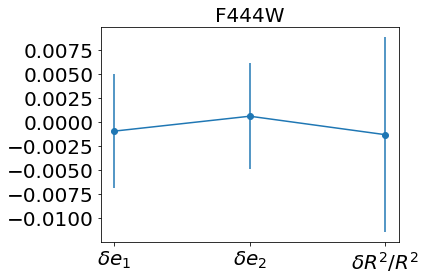

In [59]:
import numpy as np
import matplotlib.pyplot as plt
filte="F444W"
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/"+filte+"along_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/"+filte+"/catalogue/star/"+filte+"along_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/"+filte+"/catalogue/star_stamps/"+filte+"along_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/"+filte+"/catalogue/star_stamps/"+filte+"along_it0_UPDC_rev4_mask.fits"
Cam="NIRCam/"
filte="F444W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
Fts=20
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
wwshape=np.loadtxt(stamp_dirs+slicename+"_3mcwshape.cat")
indx=np.where(oshape[:,5]>100)
deshape=[]
for index in indx[0]:
    deshape.append([oshape[index][0]-wshape[index][0],oshape[index][1]-wshape[index][1],(oshape[index][2]-wshape[index][2])/oshape[index][2]])
deshape=np.array(deshape);print(deshape.shape)
dwshape=[]
for index in indx[0]:
    dwshape.append([oshape[index][0]-wwshape[index][0],oshape[index][1]-wwshape[index][1],(oshape[index][2]-wwshape[index][2])/oshape[index][2]])
dwshape=np.array(dwshape);print(dwshape.shape)
print(np.mean(deshape[:,0]),np.std(deshape[:,0]))
print(np.mean(deshape[:,1]),np.std(deshape[:,1]))
print(np.mean(deshape[:,2]),np.median(deshape[:,2]),np.std(deshape[:,2]))
plt.errorbar([1,2,3],[np.mean(deshape[:,0]),np.mean(deshape[:,1]),np.mean(deshape[:,2])],
             yerr=[np.std(deshape[:,0]),np.std(deshape[:,1]),np.std(deshape[:,2])],marker='o')
'''plt.errorbar([1,2,3],[np.mean(dwshape[:,0]),np.mean(dwshape[:,1]),np.mean(dwshape[:,2])],
             yerr=[np.std(dwshape[:,0]),np.std(dwshape[:,1]),np.std(dwshape[:,2])],marker='o')'''
plt.xticks([1,2,3],['$\delta{e_1}$','$\delta{e_2}$','$\delta{R^2}/R^2$'],fontsize=Fts)
plt.yticks(fontsize=Fts)
#plt.legend(fontsize=Fts,loc='upper left')
plt.title(filte,fontsize=Fts)
plt.tight_layout()
#plt.savefig("/home/lnie/code/JWST/co277W.pdf")

Filename: /data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it1_UPDC_rev4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  SCI           1 PrimaryHDU     113   (4772, 4772)   float32   


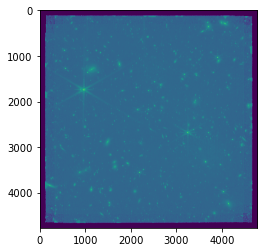

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / array data type                                
NAXIS   =                    2 / number of array dimensions                     
NAXIS1  =                 4772 / b D                                            
NAXIS2  =                 4772 / b D                                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
EXTNAME = 'SCI     '           / extension name                                 
MJD-BEG =    59737.02423385614 / [d] exposure start time in MJD                 
MJD-AVG =     59737.0291424489 / [d] exposure mid-point in MJD                  
MJD-END =    59737.03405104166 / [d] exposure end time in MJD                   
TDB-BEG =    59737.028549130

In [72]:
hdu=fits.open("/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it1_UPDC_rev4.fits")
hdu.info()
plt.imshow((hdu[0].data)**0.1);
plt.show()
hdu[0].header

In [62]:
ls /data/JWST_rev/coadd_img/rev4/parallel_field/

/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
F090Wa_it0_UPDC_rev4.fits   F277Walong_it0_UPDC_rev4.fits
F090Wa_it10_UPDC_rev4.fits  F277Walong_it10_UPDC_rev4.fits
F090Wa_it1_UPDC_rev4.fits   F277Walong_it1_UPDC_rev4.fits
F090Wa_it2_UPDC_rev4.fits   F277Walong_it2_UPDC_rev4.fits
F090Wa_it3_UPDC_rev4.fits   F277Walong_it3_UPDC_rev4.fits
F090Wa_it4_UPDC_rev4.fits   F277Walong_it4_UPDC_rev4.fits
F090Wa_it5_UPDC_rev4.fits   F277Walong_it5_UPDC_rev4.fits
F090Wa_it6_UPDC_rev4.fits   F277Walong_it6_UPDC_rev4.fits
F090Wa_it7_UPDC_rev4.fits   F277Walong_it7_UPDC_rev4.fits
F090Wa_it8_UPDC_rev4.fits   F277Walong_it8_UPDC_rev4.fits
F090Wa_it9_UPDC_rev4.fits   F277Walong_it9_UPDC_rev4.fits
F150Wa_it0_UPDC_rev4.fits   F356Walong_it0_UPDC_rev4.fits
F150Wa_it10_UPDC_rev4.fits  F356Walong_it10_UPDC_rev4.fits
F150Wa_it1_UPDC_rev4.fits   F356Walong_it1_UPDC_rev4.fits
F150Wa_it2_UPDC_rev4.fits   F356Walong_it2_UPDC_rev4.fits
F150Wa_it3_UPDC_rev4

In [44]:
ll /data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits

/bin/bash: /home/lnie/anaconda3/lib/libtinfo.so.6: no version information available (required by /bin/bash)
-rw-r--r-- 1 lwang 91091520 Feb 16  2023 /data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits


Filename: /datapool/CSST_PIPELINE/workspace/temp_data/mci/sim/L1/sim_ver230725/20100000001/ast_output/CSST_MCI_C3_EXDF_20230918003941_20230918004441_20100000001_10_L1_V01_IMG.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU      59   ()      
  1  IMAGE         1 ImageHDU       170   (9216, 9232)   float32   


/tmp/ipykernel_3884837/1299657830.py:4: RuntimeWarning: invalid value encountered in power
  plt.imshow((hdu[1].data)**0.01);


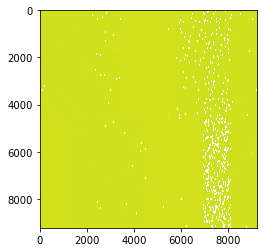

In [58]:
fname="/datapool/CSST_PIPELINE/workspace/temp_data/mci/sim/L1/sim_ver230725/20100000001/ast_output/CSST_MCI_C3_EXDF_20230918003941_20230918004441_20100000001_10_L1_V01_IMG.fits"
hdu=fits.open(fname)
hdu.info()
plt.imshow((hdu[1].data)**0.01);
plt.show()


In [50]:
from astropy.io import fits
dirs="/data/JWST_rev/"
Cam="NIRCam/"
filtes=['F277W', 'F356W', 'F444W', 'F200W', 'F150W', 'F090W']
fields=["parallel_field","cluster_field"]
para_appends=dict({'F277W':"along_it0_UPDC_rev4", 
                   'F356W':"along_it0_UPDC_rev4", 
                   'F444W':"along_it0_UPDC_rev4", 
                   'F200W':"a_it0_UPDC_rev4",
                   'F150W':"a_it0_UPDC_rev4",
                   'F090W':"a_it0_UPDC_rev4"})
clus_appends=dict({'F277W':"blong_it0_UPDC_rev4", 
                   'F356W':"blong_it0_UPDC_rev4", 
                   'F444W':"blong_it0_UPDC_rev4", 
                   'F200W':"b_it0_UPDC_rev4",
                   'F150W':"b_it0_UPDC_rev4",
                   'F090W':"b_it0_UPDC_rev4"})

/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
F277W
/home/lnie/data/JWST_rev/NIRCam/F277W//F277Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:29:42 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F277Walong_it0_UPDC_rev4.fits
----- Measuring from: F277Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1675  Objects:     9198 detected /     2302 sextracted
> Line: 1700  Objects:     9308 detected /     2354 sextracted

> WARNING: Pixel stack overflow at position 2686,1711

> Line: 1720  Objects:     9388 detected /     2400 sextracted
> Line: 1725  Objects:     9421 detected /     2419 sextracted
> Line: 1750  Objects:     9512 detected /     2490 sextracted
> Line: 1775  Objects:     9645 detected /     2566 sextracted
> Line: 1800  Objects:     9771 detected /     2638 sextracted
> Line: 1825  Objects:     9903 detected /     2680 sextracted
> Line: 1850  Objects:    10035 detected /     2731 sextracted
> Line: 1874  Objects:    10137 detected /     2800 sextracted
> Line: 1875  Objects:    10140 detected /     2804 sextracted
> Line: 1900  Objects:    10259 detected /     2874 sextracted
> Line: 1925  Objects:    10370 detected /     2929 sextracted
> Line: 1950  Objects:    10473 detected /     2990 sextracted
> Line: 1975  Objects:    10606 detected /     3059 sextracted

> Line: 4109  Objects:    21177 detected /     8400 sextracted
> Line: 4125  Objects:    21244 detected /     8446 sextracted
> Line: 4150  Objects:    21373 detected /     8524 sextracted
> Line: 4175  Objects:    21488 detected /     8602 sextracted
> Line: 4200  Objects:    21603 detected /     8677 sextracted
> Line: 4225  Objects:    21711 detected /     8761 sextracted
> Line: 4239  Objects:    21768 detected /     8800 sextracted
> Line: 4250  Objects:    21803 detected /     8833 sextracted
> Line: 4275  Objects:    21890 detected /     8912 sextracted
> Line: 4300  Objects:    22023 detected /     8988 sextracted
> Line: 4325  Objects:    22162 detected /     9055 sextracted
> Line: 4350  Objects:    22332 detected /     9106 sextracted
> Line: 4375  Objects:    22569 detected /     9175 sextracted
> Line: 4384  Objects:    22648 detected /     9200 sextracted
> Line: 4400  Objects:    22802 detected /     9251 sextracted
> Line: 4425  Objects:    23003 detected /     9325 sex

/data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it0_UPDC_rev4.fits
F356W
/home/lnie/data/JWST_rev/NIRCam/F356W//F356Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:30:05 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F356Walong_it0_UPDC_rev4.fits
----- Measuring from: F356Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1750  Objects:    10639 detected /     2635 sextracted
> Line: 1775  Objects:    10776 detected /     2698 sextracted
> Line: 1800  Objects:    10902 detected /     2775 sextracted
> Line: 1815  Objects:    10974 detected /     2800 sextracted

> WARNING: Pixel stack overflow at position 919,1821

> Line: 1825  Objects:    11034 detected /     2815 sextracted
> Line: 1850  Objects:    11188 detected /     2873 sextracted
> Line: 1875  Objects:    11331 detected /     2953 sextracted
> Line: 1900  Objects:    11474 detected /     3018 sextracted
> Line: 1925  Objects:    11605 detected /     3076 sextracted
> Line: 1950  Objects:    11728 detected /     3136 sextracted
> Line: 1975  Objects:    11840 detected /     3200 sextracted
> Line: 1976  Objects:    11840 detected /     3200 sextracted
> Line: 2000  Objects:    11971 detected /     3276 sextracted
> Line: 2025  Objects:    12141 detected /     3349 sextracted
> Line: 2050  Objects:    12290 detected /     3425 sextracted


> Line: 4200  Objects:    24650 detected /     9413 sextracted
> Line: 4225  Objects:    24744 detected /     9495 sextracted
> Line: 4250  Objects:    24827 detected /     9588 sextracted
> Line: 4253  Objects:    24834 detected /     9600 sextracted
> Line: 4275  Objects:    24919 detected /     9666 sextracted
> Line: 4300  Objects:    25053 detected /     9752 sextracted
> Line: 4325  Objects:    25184 detected /     9835 sextracted
> Line: 4350  Objects:    25340 detected /     9921 sextracted
> Line: 4373  Objects:    25526 detected /    10000 sextracted
> Line: 4375  Objects:    25538 detected /    10011 sextracted
> Line: 4400  Objects:    25716 detected /    10109 sextracted
> Line: 4425  Objects:    25939 detected /    10194 sextracted
> Line: 4450  Objects:    26174 detected /    10260 sextracted
> Line: 4475  Objects:    26424 detected /    10341 sextracted
> Line: 4500  Objects:    26719 detected /    10380 sextracted
> Line: 4525  Objects:    27043 detected /    10380 sex

/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits
F444W
/home/lnie/data/JWST_rev/NIRCam/F444W//F444Walong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:30:30 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F444Walong_it0_UPDC_rev4.fits
----- Measuring from: F444Walong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1800  Objects:    12916 detected /     3563 sextracted
> Line: 1825  Objects:    13100 detected /     3657 sextracted
> Line: 1850  Objects:    13295 detected /     3744 sextracted
> Line: 1875  Objects:    13459 detected /     3834 sextracted
> Line: 1900  Objects:    13635 detected /     3925 sextracted
> Line: 1925  Objects:    13801 detected /     4013 sextracted

> WARNING: Pixel stack overflow at position 3479,1932

> Line: 1950  Objects:    13972 detected /     4112 sextracted
> Line: 1975  Objects:    14166 detected /     4194 sextracted
> Line: 2000  Objects:    14373 detected /     4277 sextracted
> Line: 2025  Objects:    14592 detected /     4396 sextracted
> Line: 2050  Objects:    14828 detected /     4512 sextracted
> Line: 2075  Objects:    15009 detected /     4612 sextracted
> Line: 2100  Objects:    15204 detected /     4721 sextracted
> Line: 2125  Objects:    15395 detected /     4830 sextracted
> Line: 2150  Objects:    15602 detected /     4889 sextracted

> Line: 4575  Objects:    34327 detected /    13693 sextracted
> Line: 4600  Objects:    34744 detected /    13962 sextracted
> Line: 4625  Objects:    34913 detected /    14074 sextracted
> Line: 4650  Objects:    34935 detected /    14091 sextracted
> Line: 4675  Objects:    34991 detected /    14091 sextracted
> Line: 4700  Objects:    34991 detected /    14091 sextracted
> Line: 4725  Objects:    34991 detected /    14091 sextracted
> Line: 4750  Objects:    34991 detected /    14091 sextracted
> Line: 4772  Objects:    34991 detected /    14400 sextracted
> Line: 4772  Objects:    34991 detected /    14800 sextracted
> Line: 4772  Objects:    34991 detected /    15200 sextracted
> Line: 4772  Objects:    34991 detected /    15600 sextracted
> Line: 4772  Objects:    34991 detected /    16000 sextracted
> Line: 4772  Objects:    34991 detected /    16400 sextracted
> Line: 4772  Objects:    34991 detected /    16800 sextracted
      Objects: detected 34991    / sextracted 16876    

/data/JWST_rev/coadd_img/rev4/parallel_field/F200Wa_it0_UPDC_rev4.fits
F200W
/home/lnie/data/JWST_rev/NIRCam/F200W//F200Wa_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:30:58 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F200Wa_it0_UPDC_rev4.fits
----- Measuring from: F200Wa_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line: 1000  Objects:    24286 detected /     9978 sextracted
> Line: 1025  Objects:    24546 detected /    10070 sextracted
> Line: 1050  Objects:    24818 detected /    10190 sextracted
> Line: 1075  Objects:    25074 detected /    10324 sextracted
> Line: 1100  Objects:    25354 detected /    10479 sextracted
> Line: 1125  Objects:    25629 detected /    10634 sextracted
> Line: 1150  Objects:    25893 detected /    10757 sextracted
> Line: 1175  Objects:    26158 detected /    10881 sextracted
> Line: 1200  Objects:    26423 detected /    10982 sextracted
> Line: 1225  Objects:    26692 detected /    11132 sextracted
> Line: 1250  Objects:    27010 detected /    11293 sextracted
> Line: 1275  Objects:    27336 detected /    11428 sextracted
> Line: 1300  Objects:    27628 detected /    11594 sextracted
> Line: 1325  Objects:    27883 detected /    11713 sextracted
> Line: 1350  Objects:    28222 detected /    11883 sextracted
> Line: 1375  Objects:    28497 detected /    11982 sex

> Line: 3700  Objects:    56014 detected /    25565 sextracted
> Line: 3725  Objects:    56286 detected /    25718 sextracted
> Line: 3750  Objects:    56550 detected /    25862 sextracted
> Line: 3775  Objects:    56813 detected /    26007 sextracted
> Line: 3800  Objects:    57124 detected /    26172 sextracted
> Line: 3825  Objects:    57429 detected /    26312 sextracted
> Line: 3850  Objects:    57711 detected /    26423 sextracted

> WARNING: Pixel stack overflow at position 3361,3863

> Line: 3875  Objects:    57998 detected /    26561 sextracted
> Line: 3900  Objects:    58284 detected /    26704 sextracted
> Line: 3925  Objects:    58578 detected /    26858 sextracted
> Line: 3950  Objects:    58879 detected /    27024 sextracted
> Line: 3975  Objects:    59154 detected /    27159 sextracted
> Line: 4000  Objects:    59455 detected /    27308 sextracted
> Line: 4025  Objects:    59706 detected /    27409 sextracted
> Line: 4050  Objects:    59978 detected /    27548 sextracted

> Line: 6400  Objects:    94530 detected /    44140 sextracted
> Line: 6425  Objects:    94822 detected /    44269 sextracted
> Line: 6450  Objects:    95103 detected /    44418 sextracted
> Line: 6475  Objects:    95402 detected /    44558 sextracted
> Line: 6500  Objects:    95684 detected /    44639 sextracted
> Line: 6525  Objects:    95929 detected /    44776 sextracted
> Line: 6550  Objects:    96225 detected /    44916 sextracted
> Line: 6575  Objects:    96577 detected /    45107 sextracted
> Line: 6600  Objects:    96900 detected /    45271 sextracted
> Line: 6625  Objects:    97223 detected /    45452 sextracted
> Line: 6650  Objects:    97550 detected /    45605 sextracted
> Line: 6675  Objects:    97852 detected /    45707 sextracted
> Line: 6700  Objects:    98171 detected /    45882 sextracted
> Line: 6725  Objects:    98498 detected /    46054 sextracted
> Line: 6750  Objects:    98817 detected /    46217 sextracted
> Line: 6775  Objects:    99150 detected /    46385 sex

> Line: 9225  Objects:   144016 detected /    68897 sextracted

> WARNING: Pixel stack overflow at position 8204,9227

> Line: 9250  Objects:   144653 detected /    69287 sextracted

> WARNING: Pixel stack overflow at position 2067,9255

> Line: 9275  Objects:   145275 detected /    69674 sextracted
> Line: 9300  Objects:   145850 detected /    69966 sextracted
> Line: 9325  Objects:   145850 detected /    69966 sextracted
> Line: 9350  Objects:   145850 detected /    69966 sextracted
> Line: 9375  Objects:   145850 detected /    69966 sextracted
> Line: 9384  Objects:   145851 detected /    70000 sextracted
> Line: 9384  Objects:   145851 detected /    70400 sextracted
> Line: 9384  Objects:   145851 detected /    70800 sextracted
> Line: 9384  Objects:   145851 detected /    71200 sextracted
> Line: 9384  Objects:   145851 detected /    71600 sextracted
> Line: 9384  Objects:   145851 detected /    72000 sextracted
> Line: 9384  Objects:   145851 detected /    72400 sextracted
> Line

/data/JWST_rev/coadd_img/rev4/parallel_field/F150Wa_it0_UPDC_rev4.fits
F150W
/home/lnie/data/JWST_rev/NIRCam/F150W//F150Wa_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:32:40 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F150Wa_it0_UPDC_rev4.fits
----- Measuring from: F150Wa_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line: 1000  Objects:    25948 detected /    11052 sextracted
> Line: 1025  Objects:    26240 detected /    11192 sextracted
> Line: 1050  Objects:    26578 detected /    11346 sextracted
> Line: 1075  Objects:    26907 detected /    11538 sextracted
> Line: 1100  Objects:    27216 detected /    11690 sextracted
> Line: 1125  Objects:    27541 detected /    11863 sextracted
> Line: 1150  Objects:    27799 detected /    11949 sextracted
> Line: 1175  Objects:    28090 detected /    12043 sextracted
> Line: 1200  Objects:    28365 detected /    12187 sextracted
> Line: 1225  Objects:    28595 detected /    12308 sextracted
> Line: 1250  Objects:    28866 detected /    12423 sextracted
> Line: 1275  Objects:    29153 detected /    12577 sextracted
> Line: 1300  Objects:    29427 detected /    12719 sextracted
> Line: 1325  Objects:    29729 detected /    12874 sextracted
> Line: 1350  Objects:    30025 detected /    12994 sextracted
> Line: 1375  Objects:    30361 detected /    13144 sex

> Line: 3775  Objects:    60470 detected /    28142 sextracted
> Line: 3800  Objects:    60811 detected /    28318 sextracted

> WARNING: Pixel stack overflow at position 5326,3819

> Line: 3825  Objects:    61141 detected /    28479 sextracted
> Line: 3850  Objects:    61458 detected /    28642 sextracted
> Line: 3875  Objects:    61763 detected /    28781 sextracted
> Line: 3900  Objects:    62052 detected /    28923 sextracted
> Line: 3925  Objects:    62346 detected /    29082 sextracted
> Line: 3950  Objects:    62621 detected /    29225 sextracted
> Line: 3975  Objects:    62937 detected /    29380 sextracted
> Line: 4000  Objects:    63224 detected /    29520 sextracted
> Line: 4025  Objects:    63504 detected /    29668 sextracted
> Line: 4050  Objects:    63774 detected /    29816 sextracted
> Line: 4075  Objects:    64060 detected /    29967 sextracted
> Line: 4100  Objects:    64364 detected /    30090 sextracted
> Line: 4125  Objects:    64678 detected /    30265 sextracted

> Line: 6550  Objects:   101341 detected /    48084 sextracted
> Line: 6575  Objects:   101666 detected /    48266 sextracted
> Line: 6600  Objects:   102016 detected /    48452 sextracted
> Line: 6625  Objects:   102366 detected /    48654 sextracted
> Line: 6650  Objects:   102647 detected /    48791 sextracted
> Line: 6675  Objects:   102952 detected /    48894 sextracted
> Line: 6700  Objects:   103275 detected /    49071 sextracted
> Line: 6725  Objects:   103594 detected /    49224 sextracted
> Line: 6750  Objects:   103961 detected /    49425 sextracted
> Line: 6775  Objects:   104258 detected /    49564 sextracted
> Line: 6800  Objects:   104540 detected /    49725 sextracted
> Line: 6825  Objects:   104864 detected /    49857 sextracted
> Line: 6850  Objects:   105156 detected /    50014 sextracted
> Line: 6875  Objects:   105401 detected /    50153 sextracted

> WARNING: Pixel stack overflow at position 1888,6876

> Line: 6900  Objects:   105649 detected /    50297 sextracted

> Line: 9384  Objects:   152179 detected /    74800 sextracted
> Line: 9384  Objects:   152179 detected /    75200 sextracted
> Line: 9384  Objects:   152179 detected /    75600 sextracted
> Line: 9384  Objects:   152179 detected /    76000 sextracted
> Line: 9384  Objects:   152179 detected /    76400 sextracted
> Line: 9384  Objects:   152179 detected /    76800 sextracted
> Line: 9384  Objects:   152179 detected /    77200 sextracted
      Objects: detected 152179   / sextracted 77421           

> Closing files
> 
> All done (in 94.6 s: 99.2 lines/s , 818.1 detections/s)
/tmp/ipykernel_1491075/1244364085.py:21: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/data/JWST_rev/coadd_img/rev4/parallel_field/F090Wa_it0_UPDC_rev4.fits
F090W
/home/lnie/data/JWST_rev/NIRCam/F090W//F090Wa_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:34:23 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F090Wa_it0_UPDC_rev4.fits
----- Measuring from: F090Wa_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line: 1000  Objects:    28335 detected /    12353 sextracted
> Line: 1025  Objects:    28658 detected /    12508 sextracted
> Line: 1050  Objects:    28995 detected /    12670 sextracted
> Line: 1075  Objects:    29312 detected /    12835 sextracted
> Line: 1100  Objects:    29667 detected /    13023 sextracted
> Line: 1125  Objects:    29971 detected /    13184 sextracted
> Line: 1150  Objects:    30295 detected /    13346 sextracted
> Line: 1175  Objects:    30634 detected /    13477 sextracted
> Line: 1200  Objects:    30943 detected /    13641 sextracted
> Line: 1225  Objects:    31259 detected /    13817 sextracted
> Line: 1250  Objects:    31592 detected /    13942 sextracted
> Line: 1275  Objects:    31891 detected /    14093 sextracted
> Line: 1300  Objects:    32232 detected /    14265 sextracted
> Line: 1325  Objects:    32560 detected /    14421 sextracted
> Line: 1350  Objects:    32871 detected /    14583 sextracted
> Line: 1375  Objects:    33185 detected /    14764 sex

> Line: 3850  Objects:    67099 detected /    32375 sextracted
> Line: 3875  Objects:    67433 detected /    32550 sextracted
> Line: 3900  Objects:    67754 detected /    32736 sextracted
> Line: 3925  Objects:    68089 detected /    32920 sextracted
> Line: 3950  Objects:    68444 detected /    33101 sextracted

> WARNING: Pixel stack overflow at position 2378,3959

> Line: 3975  Objects:    68804 detected /    33275 sextracted
> Line: 4000  Objects:    69146 detected /    33447 sextracted
> Line: 4025  Objects:    69435 detected /    33606 sextracted
> Line: 4050  Objects:    69781 detected /    33806 sextracted
> Line: 4075  Objects:    70067 detected /    33951 sextracted
> Line: 4100  Objects:    70391 detected /    34130 sextracted
> Line: 4125  Objects:    70714 detected /    34296 sextracted
> Line: 4150  Objects:    71115 detected /    34508 sextracted
> Line: 4175  Objects:    71544 detected /    34764 sextracted
> Line: 4200  Objects:    72032 detected /    35046 sextracted

> Line: 6675  Objects:   116641 detected /    57741 sextracted
> Line: 6700  Objects:   117039 detected /    57932 sextracted
> Line: 6725  Objects:   117395 detected /    58130 sextracted
> Line: 6750  Objects:   117755 detected /    58308 sextracted
> Line: 6775  Objects:   118105 detected /    58507 sextracted
> Line: 6800  Objects:   118496 detected /    58705 sextracted
> Line: 6825  Objects:   118945 detected /    58926 sextracted
> Line: 6850  Objects:   119315 detected /    59128 sextracted
> Line: 6875  Objects:   119651 detected /    59306 sextracted
> Line: 6900  Objects:   120010 detected /    59515 sextracted
> Line: 6925  Objects:   120399 detected /    59740 sextracted
> Line: 6950  Objects:   120774 detected /    59918 sextracted
> Line: 6975  Objects:   121168 detected /    60135 sextracted
> Line: 7000  Objects:   121540 detected /    60355 sextracted
> Line: 7025  Objects:   121934 detected /    60545 sextracted
> Line: 7050  Objects:   122352 detected /    60752 sex

> Line: 9384  Objects:   176372 detected /    92000 sextracted
> Line: 9384  Objects:   176372 detected /    92400 sextracted
> Line: 9384  Objects:   176372 detected /    92800 sextracted
      Objects: detected 176372   / sextracted 93163           

> Closing files
> 
> All done (in 102.7 s: 91.4 lines/s , 907.5 detections/s)
/tmp/ipykernel_1491075/1244364085.py:21: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/data/JWST_rev/coadd_img/rev4/cluster_field/F277Wblong_it0_UPDC_rev4.fits
F277W
/home/lnie/data/JWST_rev/NIRCam/F277W//F277Wblong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:36:15 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F277Wblong_it0_UPDC_rev4.fits
----- Measuring from: F277Wblong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1675  Objects:     5291 detected /     1208 sextracted
> Line: 1700  Objects:     5344 detected /     1238 sextracted
> Line: 1725  Objects:     5401 detected /     1281 sextracted
> Line: 1750  Objects:     5462 detected /     1312 sextracted

> WARNING: Pixel stack overflow at position 3751,1752

> Line: 1775  Objects:     5534 detected /     1356 sextracted
> Line: 1800  Objects:     5613 detected /     1395 sextracted
> Line: 1825  Objects:     5670 detected /     1433 sextracted
> Line: 1850  Objects:     5729 detected /     1479 sextracted

> WARNING: Pixel stack overflow at position 830,1862

> Line: 1875  Objects:     5797 detected /     1522 sextracted
> Line: 1900  Objects:     5891 detected /     1576 sextracted
> Line: 1915  Objects:     5947 detected /     1600 sextracted
> Line: 1925  Objects:     5999 detected /     1614 sextracted
> Line: 1950  Objects:     6092 detected /     1657 sextracted
> Line: 1975  Objects:     6176 detected /     1702 sextracted
> Line:

> Line: 4175  Objects:    12203 detected /     5404 sextracted
> Line: 4200  Objects:    12237 detected /     5469 sextracted
> Line: 4225  Objects:    12263 detected /     5514 sextracted

> WARNING: Pixel stack overflow at position 539,4248

> Line: 4250  Objects:    12300 detected /     5560 sextracted
> Line: 4275  Objects:    12347 detected /     5599 sextracted
> Line: 4276  Objects:    12350 detected /     5600 sextracted
> Line: 4300  Objects:    12433 detected /     5634 sextracted
> Line: 4325  Objects:    12502 detected /     5675 sextracted
> Line: 4350  Objects:    12584 detected /     5720 sextracted

> WARNING: Pixel stack overflow at position 3830,4357

> Line: 4375  Objects:    12661 detected /     5756 sextracted
> Line: 4400  Objects:    12743 detected /     5795 sextracted
> Line: 4425  Objects:    12828 detected /     5827 sextracted

> WARNING: Pixel stack overflow at position 4637,4442

> Line: 4450  Objects:    12895 detected /     5866 sextracted
> Line: 4475  

/data/JWST_rev/coadd_img/rev4/cluster_field/F356Wblong_it0_UPDC_rev4.fits
F356W
/home/lnie/data/JWST_rev/NIRCam/F356W//F356Wblong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:36:34 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F356Wblong_it0_UPDC_rev4.fits
----- Measuring from: F356Wblong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1600  Objects:     5494 detected /     1296 sextracted
> Line: 1625  Objects:     5572 detected /     1331 sextracted
> Line: 1650  Objects:     5678 detected /     1356 sextracted
> Line: 1675  Objects:     5781 detected /     1382 sextracted
> Line: 1700  Objects:     5831 detected /     1410 sextracted
> Line: 1725  Objects:     5890 detected /     1459 sextracted
> Line: 1750  Objects:     5946 detected /     1498 sextracted

> WARNING: Pixel stack overflow at position 1745,1758

> Line: 1775  Objects:     6002 detected /     1530 sextracted
> Line: 1800  Objects:     6069 detected /     1570 sextracted
> Line: 1825  Objects:     6143 detected /     1598 sextracted
> Line: 1826  Objects:     6144 detected /     1600 sextracted
> Line: 1850  Objects:     6231 detected /     1636 sextracted
> Line: 1875  Objects:     6318 detected /     1684 sextracted

> WARNING: Pixel stack overflow at position 2295,1899

> Line: 1900  Objects:     6417 detected /     1731 sextracted
> Line

> Line: 4100  Objects:    12962 detected /     5472 sextracted

> WARNING: Pixel stack overflow at position 2443,4114

> Line: 4125  Objects:    12996 detected /     5537 sextracted
> Line: 4150  Objects:    13059 detected /     5582 sextracted
> Line: 4163  Objects:    13097 detected /     5600 sextracted
> Line: 4175  Objects:    13115 detected /     5622 sextracted
> Line: 4200  Objects:    13169 detected /     5681 sextracted
> Line: 4225  Objects:    13206 detected /     5736 sextracted
> Line: 4250  Objects:    13242 detected /     5785 sextracted
> Line: 4275  Objects:    13318 detected /     5817 sextracted
> Line: 4300  Objects:    13403 detected /     5846 sextracted
> Line: 4325  Objects:    13488 detected /     5870 sextracted

> WARNING: Pixel stack overflow at position 2449,4339

> Line: 4350  Objects:    13595 detected /     5913 sextracted
> Line: 4375  Objects:    13695 detected /     5961 sextracted
> Line: 4397  Objects:    13786 detected /     6000 sextracted
> Line

/data/JWST_rev/coadd_img/rev4/cluster_field/F444Wblong_it0_UPDC_rev4.fits
F444W
/home/lnie/data/JWST_rev/NIRCam/F444W//F444Wblong_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:36:53 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F444Wblong_it0_UPDC_rev4.fits
----- Measuring from: F444Wblong_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 4772x4772 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background 

> Line: 1700  Objects:     7874 detected /     1814 sextracted
> Line: 1725  Objects:     7951 detected /     1862 sextracted
> Line: 1750  Objects:     8031 detected /     1898 sextracted
> Line: 1775  Objects:     8116 detected /     1946 sextracted
> Line: 1800  Objects:     8213 detected /     1993 sextracted
> Line: 1804  Objects:     8223 detected /     2000 sextracted
> Line: 1825  Objects:     8307 detected /     2034 sextracted

> WARNING: Pixel stack overflow at position 2026,1831

> Line: 1850  Objects:     8401 detected /     2074 sextracted
> Line: 1875  Objects:     8519 detected /     2118 sextracted
> Line: 1900  Objects:     8631 detected /     2179 sextracted
> Line: 1925  Objects:     8760 detected /     2232 sextracted
> Line: 1950  Objects:     8860 detected /     2269 sextracted
> Line: 1975  Objects:     8952 detected /     2322 sextracted
> Line: 2000  Objects:     9031 detected /     2365 sextracted
> Line: 2016  Objects:     9089 detected /     2400 sextracted

> Line: 4225  Objects:    17362 detected /     6736 sextracted
> Line: 4250  Objects:    17408 detected /     6782 sextracted
> Line: 4258  Objects:    17427 detected /     6800 sextracted
> Line: 4275  Objects:    17498 detected /     6836 sextracted
> Line: 4300  Objects:    17612 detected /     6868 sextracted
> Line: 4325  Objects:    17743 detected /     6904 sextracted
> Line: 4350  Objects:    17886 detected /     6945 sextracted
> Line: 4375  Objects:    18062 detected /     6994 sextracted
> Line: 4400  Objects:    18207 detected /     7045 sextracted
> Line: 4425  Objects:    18375 detected /     7098 sextracted
> Line: 4450  Objects:    18545 detected /     7138 sextracted
> Line: 4475  Objects:    18706 detected /     7176 sextracted
> Line: 4485  Objects:    18829 detected /     7200 sextracted
> Line: 4500  Objects:    19071 detected /     7220 sextracted
> Line: 4525  Objects:    19343 detected /     7220 sextracted
> Line: 4550  Objects:    19688 detected /     7220 sex

/data/JWST_rev/coadd_img/rev4/cluster_field/F200Wb_it0_UPDC_rev4.fits
F200W
/home/lnie/data/JWST_rev/NIRCam/F200W//F200Wb_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:37:17 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F200Wb_it0_UPDC_rev4.fits
----- Measuring from: F200Wb_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line:  850  Objects:    12676 detected /     3715 sextracted
> Line:  875  Objects:    12890 detected /     3843 sextracted
> Line:  900  Objects:    13084 detected /     3966 sextracted
> Line:  925  Objects:    13262 detected /     4046 sextracted

> WARNING: Pixel stack overflow at position 6131,946

> Line:  950  Objects:    13431 detected /     4148 sextracted
> Line:  975  Objects:    13652 detected /     4193 sextracted
> Line: 1000  Objects:    13873 detected /     4302 sextracted
> Line: 1025  Objects:    14078 detected /     4417 sextracted
> Line: 1050  Objects:    14303 detected /     4504 sextracted
> Line: 1075  Objects:    14461 detected /     4597 sextracted
> Line: 1100  Objects:    14622 detected /     4682 sextracted
> Line: 1125  Objects:    14803 detected /     4782 sextracted
> Line: 1150  Objects:    14991 detected /     4877 sextracted
> Line: 1175  Objects:    15152 detected /     4932 sextracted
> Line: 1200  Objects:    15358 detected /     5048 sextracted


> Line: 3425  Objects:    34472 detected /    14494 sextracted

> WARNING: Pixel stack overflow at position 1787,3431

> Line: 3450  Objects:    34727 detected /    14605 sextracted
> Line: 3475  Objects:    34938 detected /    14707 sextracted
> Line: 3500  Objects:    35128 detected /    14798 sextracted

> WARNING: Pixel stack overflow at position 5557,3507

> Line: 3525  Objects:    35300 detected /    14894 sextracted
> Line: 3550  Objects:    35503 detected /    15018 sextracted
> Line: 3575  Objects:    35753 detected /    15123 sextracted

> WARNING: Pixel stack overflow at position 7358,3583

> Line: 3600  Objects:    36004 detected /    15277 sextracted
> Line: 3625  Objects:    36289 detected /    15444 sextracted
> Line: 3650  Objects:    36556 detected /    15581 sextracted
> Line: 3675  Objects:    36791 detected /    15668 sextracted
> Line: 3700  Objects:    37069 detected /    15811 sextracted
> Line: 3725  Objects:    37316 detected /    15957 sextracted

> WARNING: P

> Line: 5800  Objects:    63662 detected /    29759 sextracted
> Line: 5825  Objects:    63931 detected /    29910 sextracted
> Line: 5850  Objects:    64202 detected /    30060 sextracted
> Line: 5875  Objects:    64487 detected /    30210 sextracted
> Line: 5900  Objects:    64730 detected /    30320 sextracted

> WARNING: Pixel stack overflow at position 7532,5903

> Line: 5925  Objects:    65028 detected /    30468 sextracted
> Line: 5950  Objects:    65301 detected /    30646 sextracted
> Line: 5975  Objects:    65549 detected /    30707 sextracted
> Line: 6000  Objects:    65822 detected /    30839 sextracted
> Line: 6025  Objects:    66031 detected /    30917 sextracted
> Line: 6050  Objects:    66292 detected /    31034 sextracted
> Line: 6075  Objects:    66559 detected /    31184 sextracted
> Line: 6100  Objects:    66869 detected /    31294 sextracted
> Line: 6125  Objects:    67150 detected /    31448 sextracted
> Line: 6150  Objects:    67452 detected /    31607 sextracted


> WARNING: Pixel stack overflow at position 2811,8281

> Line: 8300  Objects:    89610 detected /    42303 sextracted
> Line: 8325  Objects:    89790 detected /    42392 sextracted

> WARNING: Pixel stack overflow at position 2839,8346

> Line: 8350  Objects:    89943 detected /    42481 sextracted
> Line: 8375  Objects:    90147 detected /    42568 sextracted

> WARNING: Pixel stack overflow at position 8099,8388

> Line: 8400  Objects:    90335 detected /    42673 sextracted
> Line: 8425  Objects:    90529 detected /    42775 sextracted
> Line: 8450  Objects:    90756 detected /    42862 sextracted

> WARNING: Pixel stack overflow at position 8282,8456

> Line: 8475  Objects:    90955 detected /    42944 sextracted
> Line: 8500  Objects:    91203 detected /    43053 sextracted

> WARNING: Pixel stack overflow at position 8346,8522

> Line: 8525  Objects:    91501 detected /    43216 sextracted
> Line: 8550  Objects:    91807 detected /    43382 sextracted
> Line: 8575  Objects:    9

/data/JWST_rev/coadd_img/rev4/cluster_field/F150Wb_it0_UPDC_rev4.fits
F150W
/home/lnie/data/JWST_rev/NIRCam/F150W//F150Wb_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:38:48 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F150Wb_it0_UPDC_rev4.fits
----- Measuring from: F150Wb_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line:  850  Objects:    14769 detected /     4934 sextracted
> Line:  875  Objects:    14999 detected /     5081 sextracted
> Line:  900  Objects:    15186 detected /     5183 sextracted
> Line:  925  Objects:    15371 detected /     5266 sextracted

> WARNING: Pixel stack overflow at position 4081,933

> Line:  950  Objects:    15576 detected /     5382 sextracted
> Line:  975  Objects:    15824 detected /     5447 sextracted
> Line: 1000  Objects:    16072 detected /     5559 sextracted
> Line: 1025  Objects:    16299 detected /     5663 sextracted
> Line: 1050  Objects:    16504 detected /     5768 sextracted
> Line: 1075  Objects:    16656 detected /     5850 sextracted
> Line: 1100  Objects:    16824 detected /     5965 sextracted
> Line: 1125  Objects:    16992 detected /     6060 sextracted
> Line: 1150  Objects:    17216 detected /     6162 sextracted
> Line: 1175  Objects:    17442 detected /     6280 sextracted
> Line: 1200  Objects:    17649 detected /     6382 sextracted


> Line: 3525  Objects:    39350 detected /    17108 sextracted
> Line: 3550  Objects:    39557 detected /    17231 sextracted
> Line: 3575  Objects:    39811 detected /    17336 sextracted
> Line: 3600  Objects:    40063 detected /    17446 sextracted
> Line: 3625  Objects:    40357 detected /    17611 sextracted
> Line: 3650  Objects:    40624 detected /    17766 sextracted

> WARNING: Pixel stack overflow at position 5305,3654

> Line: 3675  Objects:    40872 detected /    17894 sextracted
> Line: 3700  Objects:    41155 detected /    18035 sextracted
> Line: 3725  Objects:    41430 detected /    18183 sextracted
> Line: 3750  Objects:    41668 detected /    18321 sextracted
> Line: 3775  Objects:    41943 detected /    18489 sextracted
> Line: 3800  Objects:    42168 detected /    18599 sextracted
> Line: 3825  Objects:    42410 detected /    18726 sextracted

> WARNING: Pixel stack overflow at position 530,3832

> Line: 3850  Objects:    42651 detected /    18880 sextracted
> Line:

> Line: 6025  Objects:    73653 detected /    35005 sextracted
> Line: 6050  Objects:    73968 detected /    35170 sextracted
> Line: 6075  Objects:    74291 detected /    35337 sextracted
> Line: 6100  Objects:    74616 detected /    35515 sextracted
> Line: 6125  Objects:    74960 detected /    35697 sextracted
> Line: 6150  Objects:    75280 detected /    35793 sextracted
> Line: 6175  Objects:    75588 detected /    35952 sextracted
> Line: 6200  Objects:    75923 detected /    36140 sextracted
> Line: 6225  Objects:    76253 detected /    36318 sextracted
> Line: 6250  Objects:    76520 detected /    36446 sextracted
> Line: 6275  Objects:    76844 detected /    36603 sextracted
> Line: 6300  Objects:    77145 detected /    36754 sextracted
> Line: 6325  Objects:    77488 detected /    36891 sextracted
> Line: 6350  Objects:    77883 detected /    37100 sextracted
> Line: 6375  Objects:    78220 detected /    37237 sextracted
> Line: 6400  Objects:    78591 detected /    37419 sex

> Line: 8525  Objects:   103592 detected /    49613 sextracted

> WARNING: Pixel stack overflow at position 3616,8538

> Line: 8550  Objects:   103946 detected /    49827 sextracted
> Line: 8575  Objects:   104422 detected /    50065 sextracted

> WARNING: Pixel stack overflow at position 8961,8579

> Line: 8600  Objects:   104853 detected /    50285 sextracted
> Line: 8625  Objects:   105320 detected /    50536 sextracted

> WARNING: Pixel stack overflow at position 1929,8627

> Line: 8650  Objects:   105802 detected /    50778 sextracted
> Line: 8675  Objects:   106207 detected /    50971 sextracted

> WARNING: Pixel stack overflow at position 5882,8681

> Line: 8700  Objects:   106633 detected /    51196 sextracted
> Line: 8725  Objects:   107117 detected /    51402 sextracted
> Line: 8750  Objects:   107614 detected /    51662 sextracted

> WARNING: Pixel stack overflow at position 4422,8754

> Line: 8775  Objects:   108101 detected /    51936 sextracted
> Line: 8800  Objects:   10

/data/JWST_rev/coadd_img/rev4/cluster_field/F090Wb_it0_UPDC_rev4.fits
F090W
/home/lnie/data/JWST_rev/NIRCam/F090W//F090Wb_it0_UPDC_rev4.cat


> 
----- Source Extractor 2.25.0 started on 2023-09-11 at 14:40:22 with 1 thread

> Setting catalog parameters
> Reading detection filter
> Initializing Neural Network
> Reading Neural Network Weights
> Initializing check-image(s)
> Initializing catalog
> Looking for F090Wb_it0_UPDC_rev4.fits
----- Measuring from: F090Wb_it0_UPDC_rev4.fits
      "Unnamed" / no ext. header / 9384x9384 / 32 bits (floats)
Detection+Measurement image: > Setting up background maps
> Setting up background map at line:  100
> Setting up background map at line:  200
> Setting up background map at line:  300
> Setting up background map at line:  400
> Setting up background map at line:  500
> Setting up background map at line:  600
> Setting up background map at line:  700
> Setting up background map at line:  800
> Setting up background map at line:  900
> Setting up background map at line: 1000
> Setting up background map at line: 1100
> Setting up background map at line: 1200
> Setting up background map at l

> Line:  850  Objects:    18471 detected /     7273 sextracted
> Line:  875  Objects:    18789 detected /     7442 sextracted
> Line:  900  Objects:    19119 detected /     7631 sextracted
> Line:  925  Objects:    19362 detected /     7749 sextracted
> Line:  950  Objects:    19599 detected /     7852 sextracted
> Line:  975  Objects:    19857 detected /     7991 sextracted
> Line: 1000  Objects:    20126 detected /     8136 sextracted
> Line: 1025  Objects:    20390 detected /     8293 sextracted
> Line: 1050  Objects:    20656 detected /     8456 sextracted
> Line: 1075  Objects:    20860 detected /     8574 sextracted
> Line: 1100  Objects:    21136 detected /     8707 sextracted
> Line: 1125  Objects:    21442 detected /     8841 sextracted
> Line: 1150  Objects:    21711 detected /     8965 sextracted
> Line: 1175  Objects:    22035 detected /     9102 sextracted
> Line: 1200  Objects:    22329 detected /     9107 sextracted
> Line: 1225  Objects:    22639 detected /     9264 sex

> Line: 3600  Objects:    52212 detected /    24357 sextracted
> Line: 3625  Objects:    52566 detected /    24509 sextracted
> Line: 3650  Objects:    52871 detected /    24680 sextracted

> WARNING: Pixel stack overflow at position 893,3669

> Line: 3675  Objects:    53231 detected /    24859 sextracted
> Line: 3700  Objects:    53546 detected /    25021 sextracted
> Line: 3725  Objects:    53927 detected /    25227 sextracted
> Line: 3750  Objects:    54260 detected /    25406 sextracted
> Line: 3775  Objects:    54601 detected /    25566 sextracted
> Line: 3800  Objects:    54946 detected /    25753 sextracted
> Line: 3825  Objects:    55260 detected /    25924 sextracted
> Line: 3850  Objects:    55551 detected /    26086 sextracted
> Line: 3875  Objects:    55893 detected /    26268 sextracted
> Line: 3900  Objects:    56200 detected /    26373 sextracted
> Line: 3925  Objects:    56518 detected /    26498 sextracted
> Line: 3950  Objects:    56814 detected /    26673 sextracted


> Line: 6350  Objects:    96423 detected /    46970 sextracted
> Line: 6375  Objects:    96770 detected /    47124 sextracted
> Line: 6400  Objects:    97158 detected /    47343 sextracted
> Line: 6425  Objects:    97523 detected /    47527 sextracted
> Line: 6450  Objects:    97880 detected /    47721 sextracted
> Line: 6475  Objects:    98183 detected /    47879 sextracted
> Line: 6500  Objects:    98502 detected /    48044 sextracted
> Line: 6525  Objects:    98821 detected /    48220 sextracted
> Line: 6550  Objects:    99117 detected /    48378 sextracted
> Line: 6575  Objects:    99467 detected /    48531 sextracted
> Line: 6600  Objects:    99780 detected /    48637 sextracted
> Line: 6625  Objects:   100153 detected /    48783 sextracted
> Line: 6650  Objects:   100601 detected /    48955 sextracted
> Line: 6675  Objects:   100984 detected /    49162 sextracted

> WARNING: Deblending overflow for detection at 1,1

> Line: 6700  Objects:   101314 detected /    49290 sextracted
>

> Line: 9075  Objects:   141111 detected /    69787 sextracted
> Line: 9100  Objects:   142210 detected /    70408 sextracted
> Line: 9125  Objects:   143312 detected /    71089 sextracted

> WARNING: Pixel stack overflow at position 4907,9150

> Line: 9150  Objects:   144398 detected /    71753 sextracted
> Line: 9175  Objects:   145456 detected /    72367 sextracted
> Line: 9200  Objects:   146470 detected /    72955 sextracted
> Line: 9225  Objects:   147379 detected /    73484 sextracted
> Line: 9250  Objects:   148267 detected /    74024 sextracted

> WARNING: Pixel stack overflow at position 3442,9251


> WARNING: Pixel stack overflow at position 9305,9269

> Line: 9275  Objects:   149101 detected /    74524 sextracted

> WARNING: Pixel stack overflow at position 8956,9285

> Line: 9300  Objects:   149690 detected /    74900 sextracted

> WARNING: Pixel stack overflow at position 1976,9302

> Line: 9325  Objects:   150260 detected /    75182 sextracted
> Line: 9350  Objects:   15

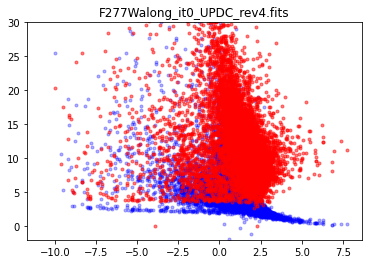

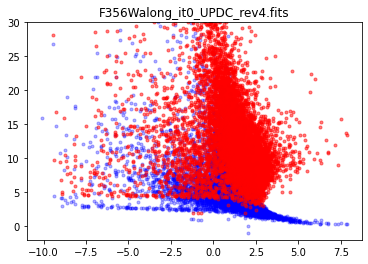

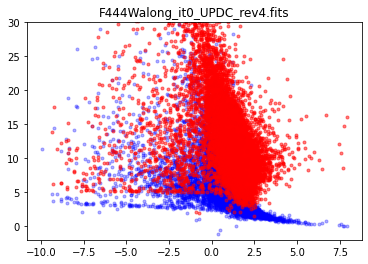

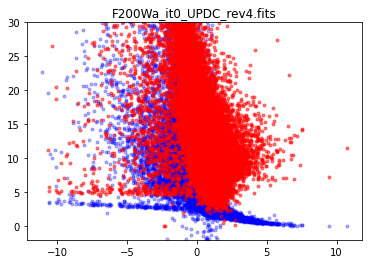

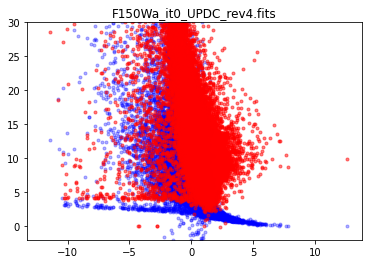

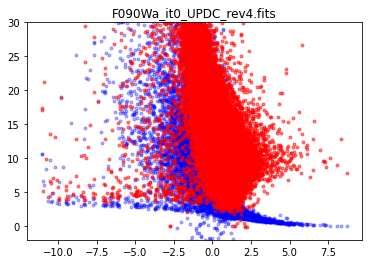

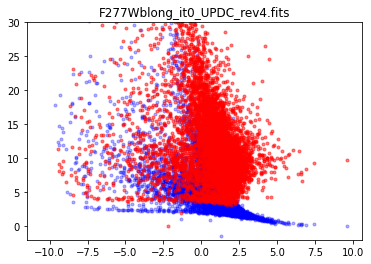

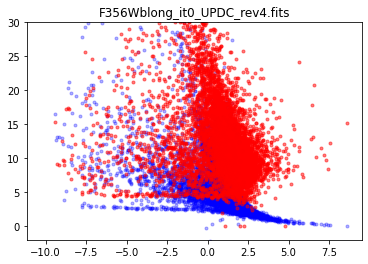

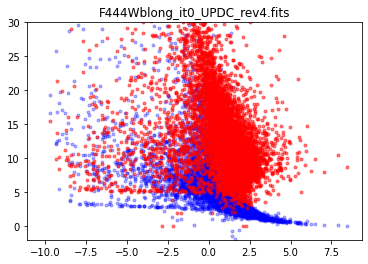

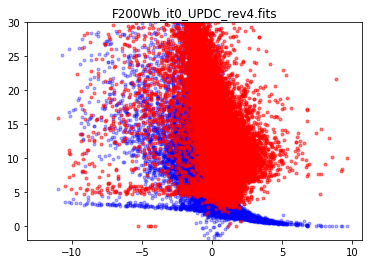

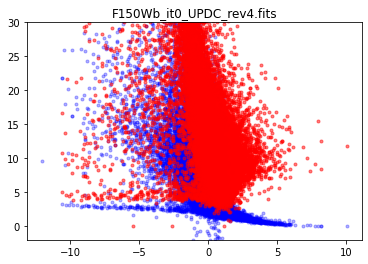

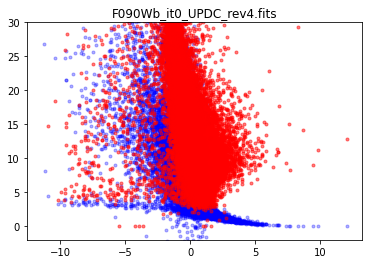

In [68]:
ofdirs="/data/JWST_rev/coadd_img/rev4/"
dirs="/home/lnie/data/JWST_rev/"+Cam
for field in fields:
    fdirs=ofdirs+field+'/'
    for filte in filtes:
        if 'para' in field:
            slicename=filte+para_appends[filte]
        else:
            slicename=filte+clus_appends[filte]
        fname=fdirs+slicename+".fits"
        print(fname)
        hdu=fits.open(fname) 
        data=hdu[0].data
        wdirs=dirs+filte+'/';print(filte)
        coldcat=wdirs+'/'+slicename+".cat";print(coldcat)
        catcmd=("source-extractor "+fname+" -CATALOG_NAME "+coldcat+" -DETECT_MINAREA 18 \
        -DETECT_THRESH 1.2 -DEBLEND_NTHRESH 64 -DEBLEND_MINCONT 0.04 -BACK_SIZE 100 \
        -BACK_FILTERSIZE 3 -BACKPHOTO_TYPE LOCAL")
        os.system(catcmd)
        cold_cat=np.loadtxt(coldcat)
        r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
        fig=plt.figure()
        plt.plot(mag,r50,'.',c='blue',alpha=0.3)
        plt.plot(mag,fwhm,'.',c='red',alpha=0.5)
        plt.ylim(-2,30)
        plt.title(slicename+".fits")
        plt.savefig(wdirs+'/'+slicename+'_cat.pdf')


/home/lnie/data/JWST_rev/NIRCam/F277W//F277Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F277W/ F277Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F277Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F277W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F277W/F277Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F277Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue'
slicename=F277Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F277W/

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F356W//F356Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F356W/ F356Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F356Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F356W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F356W/F356Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F356Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue'
slicename=F356Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F356W/

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: divide by zero encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F444W//F444Walong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F444W/ F444Walong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F444Walong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F444W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F444W/F444Walong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F444Walong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue'
slicename=F444Walong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F444W/

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: divide by zero encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F200W//F200Wa_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F200W/ F200Wa_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F200Wa_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F200W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F200W/F200Wa_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F200Wa_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue'
slicename=F200Wa_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F200W/F200Wa_it0_UPDC_rev4.cat	

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F150W//F150Wa_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F150W/ F150Wa_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F150Wa_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F150W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F150W/F150Wa_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F150Wa_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue'
slicename=F150Wa_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F150W/F150Wa_it0_UPDC_rev4.cat	

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F090W//F090Wa_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F090W/ F090Wa_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/parallel_field/ F090Wa_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F090W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F090W/F090Wa_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/parallel_field/F090Wa_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue'
slicename=F090Wa_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F090W/F090Wa_it0_UPDC_rev4.cat	

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F277W//F277Wblong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F277W/ F277Wblong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F277Wblong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F277W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F277W/F277Wblong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F277Wblong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue'
slicename=F277Wblong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F277W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F277W/F2

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F356W//F356Wblong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F356W/ F356Wblong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F356Wblong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F356W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F356W/F356Wblong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F356Wblong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue'
slicename=F356Wblong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F356W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F356W/F3

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F444W//F444Wblong_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F444W/ F444Wblong_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F444Wblong_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F444W/ -6. -0.5. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F444W/F444Wblong_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F444Wblong_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue'
slicename=F444Wblong_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F444W/F4

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F200W//F200Wb_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F200W/ F200Wb_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F200Wb_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F200W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F200W/F200Wb_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F200Wb_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue'
slicename=F200Wb_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F200W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F200W/F200Wb_it0_UPDC_rev4.cat	/d

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F150W//F150Wb_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F150W/ F150Wb_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F150Wb_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F150W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F150W/F150Wb_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F150Wb_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue'
slicename=F150Wb_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F150W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F150W/F150Wb_it0_UPDC_rev4.cat	/d

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


/home/lnie/data/JWST_rev/NIRCam/F090W//F090Wb_it0_UPDC_rev4.cat
/home/lnie/code/JWSTmc/staridf/cut /home/lnie/data/JWST_rev/NIRCam/F090W/ F090Wb_it0_UPDC_rev4.cat /data/JWST_rev/coadd_img/rev4/cluster_field/ F090Wb_it0_UPDC_rev4.fits /home/lnie/data/JWST_rev/NIRCam/F090W/ -9. -2.. 1.
catalogue:/home/lnie/data/JWST_rev/NIRCam/F090W/F090Wb_it0_UPDC_rev4.cat
fits:/data/JWST_rev/coadd_img/rev4/cluster_field/F090Wb_it0_UPDC_rev4.fits
cata path:/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue'
slicename=F090Wb_it0_UPDC_rev4
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/star_stamps/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/star/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/source/'
Directory exists at path '/home/lnie/data/JWST_rev/NIRCam/F090W//catalogue/box/'
/home/lnie/data/JWST_rev/NIRCam/F090W/F090Wb_it0_UPDC_rev4.cat	/d

/tmp/ipykernel_1491075/1917073099.py:32: RuntimeWarning: invalid value encountered in log10
  r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])


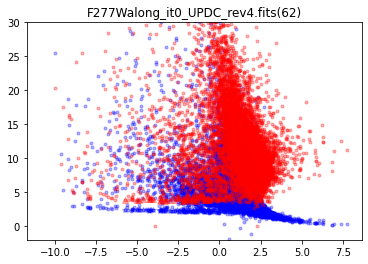

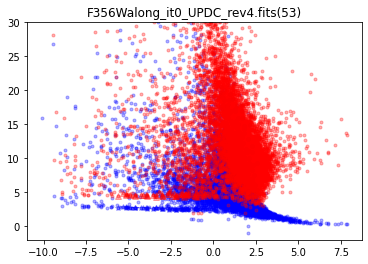

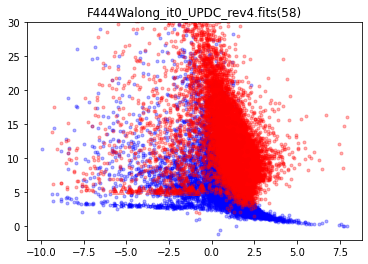

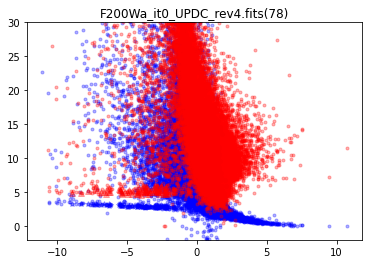

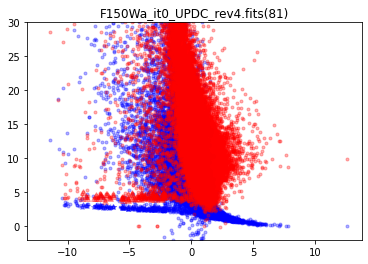

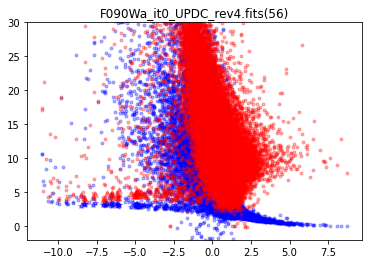

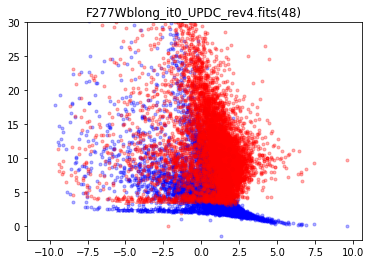

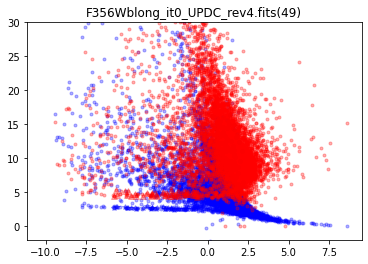

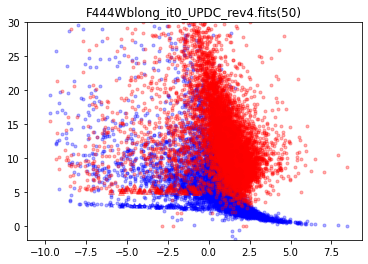

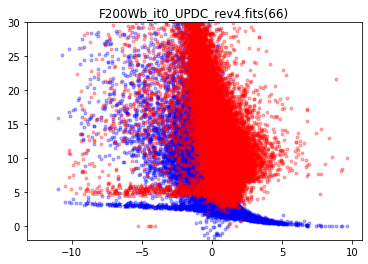

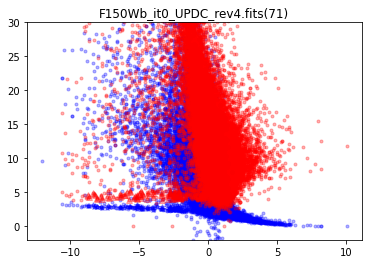

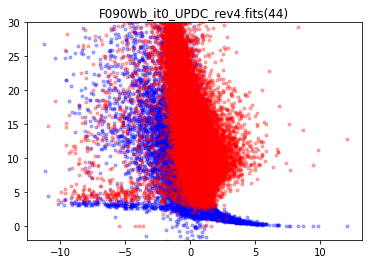

In [83]:
#find star in catalogue
fdirs="/data/JWST_rev/coadd_img/rev4/parallel_field/"
append="along_it0_UPDC_rev4"
dirs="/home/lnie/data/JWST_rev/"+Cam
catdirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'


ofdirs="/data/JWST_rev/coadd_img/rev4/"
dirs="/home/lnie/data/JWST_rev/"+Cam
for field in fields:
    fdirs=ofdirs+field+'/'
    for filte in filtes:
        if 'para' in field:
            slicename=filte+para_appends[filte]
        else:
            slicename=filte+clus_appends[filte]
        fname=fdirs+slicename+".fits"
        wdirs=dirs+filte+'/'
        coldcat=wdirs+'/'+slicename+".cat";print(coldcat)
        if 'long' in slicename:
            staridf=("/home/lnie/code/JWSTmc/staridf/cut "+wdirs+" "
                     +slicename+".cat "+fdirs+" "+slicename+".fits"+" "
                     +wdirs+" -6. -0.5. 1.")
        else:
            staridf=("/home/lnie/code/JWSTmc/staridf/cut "+wdirs+" "
                     +slicename+".cat "+fdirs+" "+slicename+".fits"+" "
                     +wdirs+" -9. -2.. 1.")
        print(staridf)
        os.system(staridf)
        cat=wdirs+slicename+".cat"
        cold_cat=np.loadtxt(cat)
        r50=cold_cat[:,4];fwhm=cold_cat[:,3];mag=-2.5*np.log10(cold_cat[:,5])
        rcat=wdirs+"catalogue/star/"+slicename+"_star"+".cat"
        try:
            rcat=np.loadtxt(rcat);
            rfwhm=rcat[:,3];rmag=-2.5*np.log10(rcat[:,5]);rr50=rcat[:,4];
            fig=plt.figure()
            plt.plot(mag,r50,'.',c='blue',alpha=0.3)
            plt.plot(mag,fwhm,'.',c='red',alpha=0.3)
            plt.plot(rmag,rfwhm,'^',c='red',alpha=0.3)
            plt.plot(rmag,rr50,'*',c='blue',alpha=0.3)
            plt.ylim(-2,30)
            plt.title(slicename+".fits"+"(%d)"%(rcat.shape[0]))
            plt.savefig(catdirs+slicename+'rcat.pdf')
        except:
            print(catdirs+slicename+".fits does not have enough stars")
            pass
        


In [2]:
#for F356W parallel field 
fn="/data/JWST_rev/coadd_img/rev4/parallel_field/F444Wblong_it1_UPDC_rev4.fits"
fn="/data/JWST_rev/coadd_img/rev4/cluster_field/F444Wblong_it1_UPDC_rev4.fits"
catname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star/F444Wblong_it0_UPDC_rev4_star.cat"
stampname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Wblong_it0_UPDC_rev4_star.fits"
maskname="/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Wblong_it0_UPDC_rev4_mask.fits"
import numpy as np
import matplotlib.pyplot as plt
from astropy.io import fits
import ctypes
import webbpsf
import os
from scipy.stats import sigmaclip
from astropy.stats import SigmaClip
from astropy.wcs import WCS

from psf_fit import star_shape,write_fits,get_filename,\
web_psf_fit,web_psf_rec,int2cent,model2pos,wgtmap,gaus_estimate\
,write_mult_fits,polyfit2d
from C_tools_lib import centriod_psf
from mcmcs import coeff2psf,interp_cubic

def size(image,center,sigma):
    '''
    size(image,center,sigma)
    center[0]=cx;center[1]=cy
    '''
    nx=image.shape[0];ny=image.shape[1]
    #print("nx=%d,ny=%d"%(nx,ny))
    W=0;R11=0;R22=0;R12=0;R2=0.;k=0;
    nh=(np.min([nx,ny])*0.5)**2
    #print("nh=%d,cx=%f,cy=%f"%(nh,center[0],center[1]))
    scale=0.5/(sigma**2)
    for i in range(nx):
        for j in range(ny):
            x=i-center[0];y=j-center[1]
            r2=x**2+y**2;weight=np.exp(-r2*scale)
            if r2<nh:
                W=W+image[i][j]*weight
                R11=R11+x*x*image[i][j]*weight
                R22=R22+y*y*image[i][j]*weight
                R12=R12+x*y*image[i][j]*weight
                #if k<10 :print(image[i][j],weight,sigma)
                #k=k+1;
    R11=R11/W;R22=R22/W;R12=R12/W
    #print("message:w11=%f,w12=%f,w22=%f,w=%f"%(R11,R12,R22,W))
    e1=(R11-R22)/(R11+R22)
    e2=(2.*R12)/(R11+R22)
    #print("message")
    R2=R11+R22
    #print(e1,e2,R2)
    if R2<=0 : R2=0.001
    if R2<=0 or np.fabs(e1)>=1. or np.fabs(e2)>=1.:
        #raise Exception("R2<=0\n")
        print("R2<=0\n");
        return(e1,e2,R2)
    else:
        return(e1,e2,R2)
    
def S2N(image,gain=1):
    Ng1=image.shape[0]
    Ng2=image.shape[1]
    weight=np.zeros(image.shape,dtype='float')
    mean,sigma=gaus_estimate(image)
    #print("method=%f,sigma=%f"%(mean,sigma))
    for i in range(Ng1):
        for j in range(Ng2):
            detx=sigma*sigma*gain*gain
            dety=gain*np.fabs(image[i][j])
            if dety<detx : error=sigma
            else : error=np.sqrt(dety+detx)/gain
            #weight[i][j]=1./(error**2)
            weight[i][j]=error
    snr=np.sum(image)/np.sqrt(np.sum(weight**2))
    return(snr)

nrca_short_detectors = ['NRCA1', 'NRCA2', 'NRCA3', 'NRCA4', 'NRCB1', 'NRCB2', 'NRCB3', 'NRCB4']
nrca_long_detectors = ['NRCA5', 'NRCB5']
F090W_fname="jw02736001001_02101_"
F150W_fname="jw02736001001_02103_"
F200W_fname="jw02736001001_02105_"
F277W_fname="jw02736001001_02101_"
F356W_fname="jw02736001001_02103_"
F444W_fname="jw02736001001_02105_"
sdetect=["nrca1","nrca2","nrca3","nrca4","nrcb1","nrcb2","nrcb3","nrcb4"]
ldetect=["nrcalong","nrcblong"]
ldetect=["nrcblong"]
detector=dict({"nrca1":"nrca1","nrca2":"nrca2","nrca3":"nrca3","nrca4":"nrca4",
               "nrcb1":"nrcb1","nrcb2":"nrcb2","nrcb3":"nrcb3","nrcb4":"nrcb4",
               "nrcalong":"nrca5","nrcblong":"nrcb5"})
filte_name=dict({"F090W":"jw02736001001_02101_","F150W":"jw02736001001_02103_",
                "F200W":"jw02736001001_02105_","F277W":"jw02736001001_02101_",
                "F356W":"jw02736001001_02103_","F444W":"jw02736001001_02105_"})
f2detpath=dict({"F090W":sdetect,"F150W":sdetect,"F200W":sdetect,
                "F277W":ldetect,"F356W":ldetect,"F444W":ldetect})
gains=dict({"nrca1":"2.08","nrca2":"2.02","nrca3":"2.17","nrca4":"2.02",
            "nrcb1":"2.01","nrcb2":"2.14","nrcb3":"1.94","nrcb4":"2.03",
            "nrcalong":"1.84","nrcblong":"1.80"})




osam=2
npc=10

Cam="NIRCam/"
filte="F444W"
odirs="/data/SMACS0723_NIRCam_pipeline1.8.1/"+filte+'/'
dirs="/home/lnie/data/JWST_rev/"+Cam+filte+'/'
PCdirs="/home/lnie/data/PC/JWST/"+Cam+filte+'/'
stamp_dirs=dirs+"/catalogue/star_stamps/"
TNg=80
ikk=0
Nim=5
cent=np.zeros(2,dtype='float')
hdu0=fits.open(fn)
cat=np.loadtxt(catname)
readstar=fits.open(stampname)[0].data
mask=fits.open(maskname)[0].data
Nobj=readstar.shape[0];Ng0=readstar.shape[1]
shapes=np.zeros((Nobj,2),dtype='float')
XPOSURE=hdu0['SCI'].header['XPOSURE']
PHOTMJSR=hdu0['SCI'].header['PHOTMJSR']
readstar*=(PHOTMJSR*XPOSURE)
#clear the candidates
for ic in range(Nobj):
    rx=cat[ic][1]+0.5;ry=cat[ic][2]+0.5
    cent[0],cent[1],sigma=centriod_psf(readstar[ic])
    oe1,oe2,or2=size(readstar[ic],cent,3.);
    mage=(oe1**2+oe2**2)**0.5
    shapes[ic][0]=mage;shapes[ic][1]=or2
cleane,low,high=sigmaclip(shapes[:,0],3.,3.)
cleanr,low,high=sigmaclip(shapes[:,1],3.,3.)
print("clean Nobj=",cleane.shape[0])
spos=np.zeros((cleane.shape[0],2),dtype='float')
instar=np.zeros((cleane.shape[0],Ng0,Ng0),dtype='float')
wgt=np.zeros(instar.shape,dtype='float');print(instar.shape,wgt.shape)
k=0
for ic in range(Nobj):
    if k <cleane.shape[0] and shapes[ic][0]==cleane[k]:
        spos[k][0]=cat[ic][1];spos[k][1]=cat[ic][2]
        instar[k]=readstar[ic].T
        wgt[k]=mask[ic].T
        k+=1
Nobj=k;print("clean Nobj=",Nobj)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
print(stamp_dirs+slicename+"_comodel.fits")
try:
    hdu=fits.open(stamp_dirs+slicename+"_comodel3.fits")
    comodel=hdu[0].data
except:
    wmodel=np.zeros((9,Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    comodel=np.zeros((Nobj,(Ng0+Nim)*osam,(Ng0+Nim)*osam),dtype='float')
    for det in f2detpath[filte]:
        gain=float(gains[det])
        stamp_dirs=dirs+det+'/'+"catalogue/star_stamps/"
        for Tim in range(9):
            expos=Tim+1
            indx=str(int(expos/10000))+str(int(expos/1000)%10)+str(int(expos/100)%10)+str(int(expos/10)%10)+str(expos%10)
            ofname=(odirs+filte_name[filte]+indx+'_'+det+"_cal.fits");print(ofname)
            stamp_name=(stamp_dirs+filte_name[filte]+indx+'_'+det+"_cal_pv181_rev4_star.fits")
            tmpname=stamp_name.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len("_star.fits")]
            hdu=fits.open(ofname);OPD=hdu[0].header['DATE-BEG'];
            print("OPD:",OPD)
            PHOTUJA2=hdu['SCI'].header['PHOTUJA2'];XPOSURE=hdu['SCI'].header['XPOSURE']
            PHOTMJSR=hdu['SCI'].header['PHOTMJSR']
            PIXAR_A2=hdu['SCI'].header['PIXAR_A2']
            nrc = webbpsf.NIRCam()
            nrc.filter =filte
            if "blong" in fn : nrc.detector="NRCA5"
            if "along" in fn : nrc.detector="NRCB5"
            nrc.load_wss_opd_by_date(OPD)
            print(filte,detector[det].upper(),OPD)
            for ic in range(Nobj):
                '''w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)'''
                w = WCS(hdu0['SCI'].header)
                wcsx,wcsy=w.wcs_pix2world(spos[ic][0],spos[ic][1],1)
                w = WCS(hdu['SCI'].header)
                ipx,ipy=w.wcs_world2pix(wcsx,wcsy,1)
                print(spos[ic][0],spos[ic][1],ipx,ipy)
                if(ipx>0 and ipx<2047 and ipy>0 and ipy<2047):
                    nrc.detector_position=(ipx,ipy)
                    psf = nrc.calc_psf(fov_pixels=Ng0+Nim,oversample=2)
                    wmodel[Tim][ic]=(psf[2].data/np.sum((psf[2].data))).T              
    for ic in range(Nobj):
        for ex in range(9):
            if wmodel[ex][ic].any!=0:
                comodel[ic,:,:]+=wmodel[ex,ic,:,:]
        comodel[ic]/=np.sum(comodel[ic])
    stamp_dirs=dirs+"/catalogue/star_stamps/"
    tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")] 
    write_fits(stamp_dirs+slicename+"_comodel.fits",comodel)


tmpname=fn.split("/");l0=len(tmpname);l1=len(tmpname[l0-1]);slicename=tmpname[l0-1][0:l1-len(".fits")]  
PCs,pos,coeff,getNobj,slecstar,webcoeff,slecwgt,slecimodel=web_psf_fit(
    instar,
    spos,
    npc,
    gain=1.84,
    method=1,
    wgt=wgt,
    imodel=comodel,
    osam=2,
    SNRs=5)
wgt=slecwgt;comodel=slecimodel
polyorder=2
if getNobj>10:polyorder=3
if getNobj>15:polyorder=4
if getNobj>21:polyorder=5
rPSF=coeff2psf(pos,coeff,PCs,pos,degrees=polyorder);print("rPSF",rPSF.shape)
icoeff=polyfit2d(pos,webcoeff[:,0],webcoeff[:,1],pos,polyorder)
eNg=rPSF.shape[1]
Ng=int(eNg/osam)
sNg=30;dpix=int((slecstar.shape[1]-sNg)/2);cut=int(((Ng0+Nim)*osam-eNg)/2)
mix_mod=np.zeros(rPSF.shape,dtype='float')
rrPSF=np.zeros((getNobj,sNg,sNg),dtype='float')
chi1=np.zeros((getNobj,sNg,sNg))
chi2=np.zeros((getNobj,sNg,sNg))
residu1=np.zeros((getNobj,sNg,sNg))
residu2=np.zeros((getNobj,sNg,sNg))
fp=open(stamp_dirs+slicename+"_3mcoshape.cat","w")
fpw=open(stamp_dirs+slicename+"_3mcwshape.cat","w")
fpm=open(stamp_dirs+slicename+"_3mcmshape.cat","w")
for ic in range(getNobj):
    mean,sigma=gaus_estimate(slecstar[ic]);
    print(ic,mean,sigma)
    #mean,sigma=gaus_estimate(rPSF[ic]);rPSF[ic]-=mean
    slecstar[ic]-=mean
    #slecstar[ic]*=wgt[ic]
    snrs=S2N(slecstar[ic],gain=1.84)
    slecstar[ic]/=np.sum(slecstar[ic])
    tmp=wgtmap(slecstar[ic])
    tmp_img=slecstar[ic][dpix:dpix+sNg,dpix:dpix+sNg]
    tmp_wgt=wgt[ic][dpix:dpix+sNg,dpix:dpix+sNg]#mask
    tmp_img*=tmp_wgt
    #tmp_img/=np.sum(tmp_img) #normalise
    error_map=tmp[dpix:dpix+sNg,dpix:dpix+sNg];#error_map/=sums  #weight map
    tmp_wmap=1./(error_map*error_map)*tmp_wgt;
    cent[0],cent[1],sigma=centriod_psf(tmp_img);
    print(cent[0],cent[1])
    dx=cent[0]-(sNg/2.+0.5)+1;dy=cent[1]-(sNg/2.+0.5)+1
    rrPSF[ic]=interp_cubic(rPSF[ic],sNg,dy,dx,osam=2)
    tmp_mod=interp_cubic(comodel[ic],sNg,dy,dx,osam=2)
    #print("sum:", np.sum(rrPSF[ic]))
    #mean,sigma=gaus_estimate(rrPSF[ic]);rrPSF[ic]-=mean
    rrPSF[ic]=rrPSF[ic].T;
    tmp_mod*=tmp_wgt;
    frac=(1.-np.sum(comodel[ic,cut:cut+eNg,cut:cut+eNg]))
    #rPSF=rPSF/np.sum(rPSF)*frac
    #tmp_mod/=np.sum(tmp_mod)
    for i in range(eNg):
        for j in range(eNg):
            mix_mod[ic][i][j]=0
            mix_mod[ic][i][j]=(rPSF[ic][i][j]+comodel[ic][i+cut][j+cut]*icoeff[ic])#mixture model
            if mix_mod[ic][i][j]<0 : mix_mod[ic][i][j]=0
    for i in range(eNg):
        for j in range(eNg):
            if mix_mod[ic][i][j]==0 and i-1>0 and i+1<eNg and j-1>0 and j+1<eNg:
                mix_mod[ic][i][j]=(mix_mod[ic][i-1][j-1]+mix_mod[ic][i-1][j]+mix_mod[ic][i-1][j+1]+
                                   mix_mod[ic][i][j-1]+mix_mod[ic][i][j+1]+
                                   mix_mod[ic][i+1][j-1]+mix_mod[ic][i+1][j]+mix_mod[ic][i+1][j+1])/8.
    tmp_mix_mod=interp_cubic(mix_mod[ic],sNg,dy,dx,osam)
    tmp_mix_mod*=tmp_wgt;
    print(np.sum(tmp_img),np.sum(tmp_mix_mod))
    #mean,sigma=gaus_estimate(tmp_mix_mod);tmp_mix_mod-=mean
    tmp_img/=np.sum(tmp_img);tmp_mod/=np.sum(tmp_mod);tmp_mix_mod/=np.sum(tmp_mix_mod)
    residu1[ic]=(tmp_img-tmp_mod).T
    residu2[ic]=(tmp_img-tmp_mix_mod).T
    oe1,oe2,or2=size(tmp_img,cent,3.);
    we1,we2,wr2=size(tmp_mod,cent,3.);
    me1,me2,mr2=size(tmp_mix_mod,cent,3.);
    print(oe1,oe2,or2)
    print(me1,me2,mr2)
    fpw.writelines(str(we1)+'\t'+str(we2)+'\t'+str(wr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fp.writelines(str(oe1)+'\t'+str(oe2)+'\t'+str(or2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    fpm.writelines(str(me1)+'\t'+str(me2)+'\t'+str(mr2)+'\t'+str(spos[ic][0])+'\t'+str(spos[ic][1])+'\t'+str(snrs)+'\n')
    chi1[ic]=residu1[ic]*residu1[ic]*tmp_wmap
    chi2[ic]=residu2[ic]*residu2[ic]*tmp_wmap
#write_fits("fits/rPSF.fits",rrPSF)
fp.close();fpw.close();fpm.close()
write_fits(stamp_dirs+slicename+"_webchi.fits",chi1)
write_fits(stamp_dirs+slicename+"_mixchi.fits",chi2)
write_fits(stamp_dirs+slicename+"_webresidu.fits",residu1)
write_fits(stamp_dirs+slicename+"_mixresidu.fits",residu2)  
#write_fits("fits/ostars.fits",instar)
oshape=np.loadtxt(stamp_dirs+slicename+"_3mcoshape.cat")
wshape=np.loadtxt(stamp_dirs+slicename+"_3mcmshape.cat")
de1=oshape[:,0]-wshape[:,0];de2=oshape[:,1]-wshape[:,1];dr=(oshape[:,2]**0.5-wshape[:,2]**0.5)
print(np.mean(oshape[:,0]),np.mean(oshape[:,1]),np.mean(oshape[:,2]))
print(np.mean(de1),np.std(de1),np.mean(de2),np.std(de2),np.median(dr),np.std(dr),
      np.mean((oshape[:,2]-wshape[:,2])/oshape[:,2]))

        



**WARNING**: LOCAL JWST PRD VERSION PRDOPSSOC-059 CANNOT BE CHECKED AGAINST ONLINE VERSION


clean Nobj= 44
(44, 80, 80) (44, 80, 80)
clean Nobj= 44
/home/lnie/data/JWST_rev/NIRCam/F444W//catalogue/star_stamps/F444Wblong_it1_UPDC_rev4_comodel.fits
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00001_nrcblong_cal.fits
OPD: 2022-06-07T05:18:31.388

MAST OPD query around UTC: 2022-06-07T05:18:31.388
                        MJD: 59737.22119662037

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3082 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8370 days
User requested choosing OPD time closest in time to 2022-06-07T05:18:31.388, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.837 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field p

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 422.550242881279 571.4792585793027


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -47.71583285926113 1478.2944164504217
3410.202 1531.492 1512.5221702176689 606.247239824514


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1260.1668732396922 1431.4875093048931


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 531.5407821228293 1847.3704730422164


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1214.3998198054187 538.6173147247912


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 594.2574516561336 523.2747898554936


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1560.3266904134134 724.671308339781


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1879.0662516457664 619.4146681156346


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 64.34022197909269 141.59233766549562


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 30.399955654669384 1416.4553494298934


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 803.6922523758124 1461.9608036282941


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 157.63882553518124 860.1592228164741


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1429.2874387816382 224.44297979121677


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 199.1531820060211 1434.6778344905465


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1550.7349883201314 137.1429895460725


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 343.18030296054155 73.87577222373966


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1100.2620119154071 540.4379352392795


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 556.4808079271904 99.68546744738956


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1988.957055768315 929.4527986734779


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 1999.5929856855985 241.52245174395648


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1796.937155034743 233.6050271246478


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1474.0534913632707 631.2633889180208


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 828.0786527241698 1328.3209940222098


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1896.743651339557 1674.5700841621388


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 508.18583931799174 1782.2341424540473


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1234.1679333550144 1787.3798651064262


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 828.7650856369139 2074.2717566825486
1758.498 3980.632 700.2567483374762 1796.5294048724666


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 912.9784372464753 1273.1614059410588


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 88.31145265100895 2026.1098739019244


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.649855e+03 1169.476 1142.0606304940588 428.05601302683124


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1882.8015378422053 443.0228483802525


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1545.938840579029 713.6564949310693


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 340.9024951527373 1602.2511965239905


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1533.528226394732 803.6760998647841


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -12.434489524282753 782.7600986606642
1982.904 951.6912 816.8725543831636 320.3885083896405


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 371.5026200581407 75.02541997883918


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1484.7752900810274 535.9371528501781


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1440.7408218458386 262.53652295775817


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2041.327025000125 1770.3185823252677


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:25:35.491' from MJD-AVG.
Set DATE-END to '2022-06-07T05:32:39.593' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.915137 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675662443.902 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1500.1760099023397 1408.0296896504901
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00002_nrcblong_cal.fits
OPD: 2022-06-07T05:33:54.715

MAST OPD query around UTC: 2022-06-07T05:33:54.715
                        MJD: 59737.23188327546

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3189 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8263 days
User requested choosing OPD time closest in time to 2022-06-07T05:33:54.715, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.826 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T05:33:54.715
2.338469e+03 1024.526 987.3664183967019 451.7101602816

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 419.5795869621171 666.4967559588954


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -50.68551327150135 1573.3124219324175
3410.202 1531.492 1509.5515530195948 701.2635646191275


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1257.1971536931592 1526.5041072386314


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 528.5715062046029 1942.387860394701


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1211.429128799223 633.6339605848467


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 591.2867437448228 618.2921028424316


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1557.3562024129856 819.6875812044759


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1876.0956490926856 714.430598577661


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 61.36910251467418 236.61022439288513


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 27.430209368866144 1511.4732702510819


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 800.7225620371007 1556.9778929548484


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 154.6684805726602 955.1770042590205


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1426.31640553743 319.459397451157


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 196.18345684637097 1529.6955739354682


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1547.763859549481 232.15927771666384


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 340.2091096264628 168.89336000157232


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1097.291322846842 635.4547038545073


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 553.5096417848393 194.70282545436578


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1985.9867926220672 1024.4686101628547


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 1996.6219695750683 336.5382558213578


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1793.9661308159584 328.6210492583713


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1471.0829013993293 726.2797549630321


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 825.1088177135442 1423.3380559253885


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1893.7742027921022 1769.5860000131331


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 505.21649268007593 1877.251553863183


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1231.1986007226544 1882.396495488962


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 825.7960593615203 2169.2888285357058
1758.498 3980.632 697.2874194328398 1891.546609854661


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 910.0085430326976 1368.178376112588


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 85.34236381530673 2121.1277414907527
2649.855 1169.476 1139.089819288056 523.0727375193421


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1879.8307423985907 538.0387760225132


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1542.9683405398678 808.6727833092033


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 337.93295218953574 1697.2687853458856


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1530.5578244947903 898.6924013541584


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -15.40491846556256 877.7780631359979
1982.904 951.6912 813.9016266342645 415.4055836492819


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 368.5314278705364 170.04297728000233


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1481.8045962220383 630.9535079109216


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1437.7698300792908 357.5529278495625


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2038.3576827456523 1865.3343439950056


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:40:58.818' from MJD-AVG.
Set DATE-END to '2022-06-07T05:48:02.920' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.918606 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675719328.081 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1497.2062667487717 1503.046029158358
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00003_nrcblong_cal.fits
OPD: 2022-06-07T05:49:28.858

MAST OPD query around UTC: 2022-06-07T05:49:28.858
                        MJD: 59737.24269511574

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3297 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8155 days
User requested choosing OPD time closest in time to 2022-06-07T05:49:28.858, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.815 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T05:49:28.858
2.338469e+03 1024.526 1082.8317532250373 454.5404425285

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 515.0447759898984 669.3266498520296


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 44.77905319265301 1576.1419867823374


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410202e+03 1531.492 1605.016716706521 704.0942046071508


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1352.6617431278685 1529.3345774447725


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 624.035808527763 1945.217825388823


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1306.8943376549053 636.4643962660805


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 686.7519646434761 621.1221143623928


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1652.8212843613837 822.5182546419519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1971.560807971735 717.2614896323225


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 156.83459499506114 239.43987630890433


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 122.89481734550384 1514.302889621812


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 896.1871302012928 1559.8080472955082


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 250.133472666177 958.0067150406552


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1521.781833501248 322.28997862520794


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 291.6480494723712 1532.5253099519023


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1643.2293490639297 234.9899411266963


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 435.6746449940729 171.72320201246703


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1192.7565301831382 638.28506146559


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 648.9751570115242 197.53281241045238


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 2081.4517381829683 1027.2995795501106
4404.041 778.7872 2092.0873925514984 339.3692256837144
3988.977 764.455 1889.4315561862998 331.45188096697404


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1566.5480474129572 729.1103687459068


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 920.5734785431822 1426.1682271478119


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1989.2386299236166 1772.416913024954


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 600.680840419559 1880.0815027808035


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1326.6629430847877 1885.2269490293013


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 921.2602024628261 2172.119000364083
1758.498 3980.632 792.7517558634287 1894.3766922596774


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 1005.47324192171 1371.008605964368


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 180.80654755234036 2123.9573970402453
2649.855 1169.476 1234.5551046805533 525.903123465328


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1975.2960237076445 540.8696680695987


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1638.4334299980746 811.5034468148691


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 433.39742661140883 1700.098618738253


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1626.0228513793516 901.5230568825318


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 80.06013023955802 880.6076576973851


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.982904e+03 951.6912 909.366987060485 418.23574754375295


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 463.99696209788624 172.87283854246198


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1577.2698084646447 633.7841285247225


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1533.235231691694 360.3835170091744


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T05:56:32.961' from MJD-AVG.
Set DATE-END to '2022-06-07T06:03:37.063' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.922305 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675779992.885 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2133.8220459069544 1868.165358411624
3392.738 3176.215 1592.6708740052102 1505.8766652991085
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00004_nrcblong_cal.fits
OPD: 2022-06-07T06:04:52.185

MAST OPD query around UTC: 2022-06-07T06:04:52.185
                        MJD: 59737.25338177083

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3404 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.8048 days
User requested choosing OPD time closest in time to 2022-06-07T06:04:52.185, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.805 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T06:04:52.185

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 518.0095257091612 574.3098280675932


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 47.740450053519226 1481.123444810336


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410202e+03 1531.492 1607.9813388618627 609.0813843288499


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1355.623304508372 1434.3208366955184


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 626.9958349141622 1850.201408163981


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1309.859210225205 541.4504806422469


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 689.7168930329769 526.1059221295624


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1655.785467078751 727.5056114378988


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1974.5253817367927 622.2500150325864


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 159.80093405962316 144.42173164512064


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 125.8564422974149 1419.2846344628294


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 899.1485815662518 1464.7926308303952


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 253.09715437045088 862.9889243636695


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1524.7478720714184 227.27684598163194


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 294.6096058971033 1437.507674269361


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1646.195712188673 139.97725234323707


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 438.6412359648532 76.7060793006292


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1195.7213958074958 543.2707269014572


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 651.9416535983694 102.51647324532519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 2084.415160292186 932.2885119416125
4404.041 778.7872 2095.053370415523 244.3581867889302
3988.977 764.455 1892.3975624855123 236.4400980277951


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1569.5125766956844 634.0974076173343


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 923.535424843521 1331.1529001657998


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1992.1992846163919 1677.4055085759455


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 603.6411081719376 1785.0650002924826


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1329.62318485791 1790.2131116213227


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 924.2193852160733 2077.1036720468824
1758.498 3980.632 795.7119688201446 1799.3608947765365


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 1008.4353921508581 1275.9935905348893


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 183.7659175365893 2028.9393509833724


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.649855e+03 1169.476 1237.5203870329183 430.8889404685149


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1978.261252618448 445.85820436684594


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1641.3976535883899 716.4907506584772


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 436.3583619978722 1605.0815030694027


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1628.9867409031185 806.5103162324798


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 83.02409839861764 785.5892419191157


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.982904e+03 951.6912 912.3326674293662 323.2203688950136


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 466.96354896806224 77.85581981683526


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1580.234691473096 538.7712053318743


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1536.20112898065 265.3704272066195


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:11:56.288' from MJD-AVG.
Set DATE-END to '2022-06-07T06:19:00.390' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.925772 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675836855.174 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2136.782343691403 1773.1544842300518
3392.738 3176.215 1595.6325209648194 1410.8638056138054
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00005_nrcblong_cal.fits
OPD: 2022-06-07T06:20:15.576

MAST OPD query around UTC: 2022-06-07T06:20:15.576
                        MJD: 59737.26406916667

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3511 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.7941 days
User requested choosing OPD time closest in time to 2022-06-07T06:20:15.576, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.794 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T06:20:15.576

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 520.977898819426 479.2916446477876


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 50.70689092725934 1386.1042715596536


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.410202e+03 1531.492 1610.9496423824075 514.0655090593043


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1358.589840637787 1339.3044327956823


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 629.9614859479489 1755.1834596514404


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1312.827657157895 446.43397319720907


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 692.6853697615342 431.0881015140443


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1658.7535170330939 632.4898389427414


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1977.4936586805586 527.234915984287


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 162.7702212129916 49.40278195924316


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 128.8230145305398 1324.2656266828749


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 902.1150540232331 1369.7752603699955


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 256.06491135072565 767.9701835347312


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1527.7169929814934 132.26078775479846


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 297.5761387131222 1342.4890237922282


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1649.1650211301853 44.961449321288


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 441.6106697104319 -18.312281614341828
2565.358 1400.386 1198.689838287792 448.2539778372394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 654.9110341113994 7.49856449350807


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 2087.382772145117 837.273649082535
4404.041 778.7872 2098.022459211371 149.34333629564128
3988.977 764.455 1895.366666657158 141.42481833325826


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1572.4808264550682 539.0814512533461


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 926.5021827328695 1236.1355813369473


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1995.1652972845063 1582.3904519433231


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 606.6068983477219 1690.0470028170162


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1332.5889594228447 1695.1966513601476


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 927.1845493947151 1982.0863506253977


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.758498e+03 3980.632 798.6777272274967 1704.3433039057404


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 1011.4022677342796 1180.9764513734722


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 186.73119107150455 1933.920462181551


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.649855e+03 1169.476 1240.4890701314068 335.8722780628714


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1981.229908090858 350.84311045952836


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1644.3657270955332 621.4749475669631


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 439.3245370207686 1510.0631523454222


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1631.954621476102 711.4944879050024


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 85.99201991182349 690.5701402290156


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.982904e+03 951.6912 915.3015786653136 228.2030160658121


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 469.9329805061052 -17.162481112140995
3352.698 1387.534 1583.2031454983921 443.7552702697716


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1539.1701683873816 170.35439401508881


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:27:19.679' from MJD-AVG.
Set DATE-END to '2022-06-07T06:34:23.781' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.929468 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675897496.540 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2139.748150068195 1678.139733220905
3392.738 3176.215 1598.5991066450124 1315.8479099092967
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00006_nrcblong_cal.fits
OPD: 2022-06-07T06:35:38.903

MAST OPD query around UTC: 2022-06-07T06:35:38.903
                        MJD: 59737.27475582176

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3617 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.7834 days
User requested choosing OPD time closest in time to 2022-06-07T06:35:38.903, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.783 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T06:35:38.903


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 425.51898904443533 476.4584432907949


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -44.74874500296937 1383.2727645443151
3410.202 1531.492 1515.4908704129373 511.2284011914538


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1263.1340574072633 1336.4682280028346


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 534.5072007521658 1752.34987358023


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1217.3686390363382 443.5979339437523


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 597.2262886122544 428.25428455836095


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1563.295174105516 629.6525592374464


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1882.0349336592658 524.3964942452534


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 67.30974544502305 46.57086042974095


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.830984e+02 3207.335 33.36715673384106 1321.433838526374


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.967045e+03 3293.395 806.6593768596338 1366.9406950930895


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 160.60704140725773 765.1379339723319


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1432.2568376997817 129.42397932555218


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 202.12035128403807 1339.6566297080217


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1553.7045498002867 42.12420634123066


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 346.1499554485449 -21.145201891883744
2565.358 1400.386 1103.230825903665 445.4183476123096


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 559.4504176620275 4.664880832767494


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1991.9251695516639 834.4348309591932


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 2002.562364503991 146.50448555377784


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1799.9065443916174 138.58669334888805


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1477.0221450500464 536.24448118232


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 831.0460217387616 1233.3009282160126


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1899.710394505943 1579.5519589896044


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 511.1523767372116 1687.213500419387


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1237.1344653440942 1692.3605392953627


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 831.7310908654274 1979.2516963178277


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.758498e+03 3980.632 703.223260667656 1701.5091111189276


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 915.9459079594525 1178.1414933419278


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 91.27754362516407 1931.0884710819987


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.649855e+03 1169.476 1145.0296509572972 333.0364980890106


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1885.7705440633827 348.004676562373


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1548.9073442603117 618.6377194901493


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 343.8693599645253 1507.2302501866006


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1536.4965647412591 708.6573039616827


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -9.46613498809279 687.73849988455
1982.904 951.6912 819.8417659490168 225.36840085356346


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 374.4722710281176 -19.9955027611245
3352.698 1387.534 1487.744118778475 440.9182620987525


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1443.7101511365734 167.51754446252085


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 2044.293593098666 1675.3007198111227


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:42:43.006' from MJD-AVG.
Set DATE-END to '2022-06-07T06:49:47.108' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.932933 from OBSGEO-[XYZ].
Set OBSGEO-H to 1675954336.772 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1503.1432392320548 1313.0108432075563
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00007_nrcblong_cal.fits
OPD: 2022-06-07T06:51:02.295

MAST OPD query around UTC: 2022-06-07T06:51:02.295
                        MJD: 59737.285443229164

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3724 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.7727 days
User requested choosing OPD time closest in time to 2022-06-07T06:51:02.295, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.773 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T06:51:02.295
2.338469e+03 1024.526 897.8409273283039 258.843785575

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 330.05354456599696 473.6289856291618


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -140.21381578546425 1380.4435156089783
3410.202 1531.492 1420.0254497916753 508.39849183266654


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1167.6689858358293 1333.6384263225314


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 439.042298426141 1749.5203835033972


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1121.9031893846188 440.7681479464002


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 501.76082656010226 425.42475525714997


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1467.8298035185733 626.8226301888203


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1786.5695169486003 521.566432831584


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 -28.15588873302454 43.741544951284936
383.0984 3207.335 -62.09793825539373 1318.6045557016653
1967.045 3293.395 711.1943149900235 1364.1110863132021


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 65.14171379899847 762.3085900298904


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1336.7912555410594 126.5941035412934


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 106.65526794001562 1336.8272759108077


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1458.2389306031723 39.29428046197779


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 250.68429873947355 -23.974632709991056
2565.358 1400.386 1007.765376447976 442.5886088975053


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 463.98477565916073 1.8353628186537208


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1896.4598830410166 831.6047231226337


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 1907.0967868588868 143.6743751095546


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1704.4409650214266 135.75666631140348


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1381.556735052831 533.4145878275123


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 735.5809035537457 1230.4713081642133


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1804.2454240721431 1576.721888059444


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 415.6874464551843 1684.3840196435522


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1141.6695443261367 1689.5307498508225


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 736.2662885064404 1976.422081268353


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.758498e+03 3980.632 607.7583392214075 1698.6795487933307


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 820.4807672623442 1175.3118371707637


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 -4.1872917202676945 1928.259172140153
2649.855 1169.476 1049.564154168587 330.2067415007183


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1790.305052694486 345.17461388186916


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1453.441969040233 615.8077964113036


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 248.40435049858058 1504.4008384847957


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1441.0312276378704 705.8273861653552


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -104.93149949550002 684.9092257027855
1982.904 951.6912 724.3762209033998 222.5387777769754


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 279.0066153545298 -22.82494517824989
3352.698 1387.534 1392.2786684320913 438.08836411360164


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1348.2445851014768 164.68766406105397


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 1948.8286617708372 1672.4705871903434


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T06:58:06.398' from MJD-AVG.
Set DATE-END to '2022-06-07T07:05:10.500' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.936627 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676014954.522 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1407.6781579342723 1310.1809401917953
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00008_nrcblong_cal.fits
OPD: 2022-06-07T07:06:25.622

MAST OPD query around UTC: 2022-06-07T07:06:25.622
                        MJD: 59737.29612988426

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3831 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.7620 days
User requested choosing OPD time closest in time to 2022-06-07T07:06:25.622, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.762 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T07:06:25.622
2.338469e+03 1024.526 894.874184971814 353.85970826731

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 327.08750170957103 568.6467424765564


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -143.1769080742863 1475.4627918220913
3410.202 1531.492 1417.0595237509797 603.4127221899997


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1164.705755209458 1428.653470897445


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 436.0804161308057 1844.537788980902


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1118.9370415252258 535.7833434665499


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 498.7946270366674 520.4419571434581


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1464.8642648394639 721.8367048287948


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1783.6036350312124 616.579477259597


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 -31.123332677789676 138.76046669739026
383.0984 3207.335 -65.06123100669993 1413.6235788571962
1967.045 3293.395 708.231179002078 1459.1276078715216


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 62.1766104024764 857.327201649253


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1333.824081277775 221.60860829565354


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 103.69203638494832 1431.845753190135


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1455.271470835956 134.30839387504523


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 247.7166339595036 71.04338826394519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1004.7992342495468 537.6041736399022


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 461.0171947697877 96.85269328841969


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1893.4950163793146 926.6174098204583


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 1904.1296681683361 238.68703465249575


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1701.473820535459 230.76998157391984


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1378.5908906783523 628.4289423884479


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 732.6173317271123 1325.487750266448


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1801.2829955144675 1671.734874756464


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 412.72535144963854 1779.4014999176918


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1138.7074760929381 1784.5458813513


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 733.3051509360773 2071.438528341546
1758.498 3980.632 604.7962935122958 1793.6964078039364


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 817.5170162141991 1270.328004463294


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 -7.148598384601883 2023.2780141477388
2649.855 1169.476 1046.5976450279006 425.22217238476117


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1787.338593516109 440.1876482500686


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1450.47639429013 710.821917685526


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 245.44166660603207 1599.4188582545144


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1438.065947163879 800.8415469292563


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -107.89685589575265 779.9283879827433
1982.904 951.6912 721.409359903318 317.55526215967984


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 276.0389542857895 72.19298415119601


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1389.3125124577123 533.1026849841394


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1345.2775353510024 259.70213113510215


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 1945.8665484630235 1767.4831070368748


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:13:29.725' from MJD-AVG.
Set DATE-END to '2022-06-07T07:20:33.827' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.940089 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676071772.529 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1404.7148530972308 1405.1952081630793
/data/SMACS0723_NIRCam_pipeline1.8.1/F444W/jw02736001001_02105_00009_nrcblong_cal.fits
OPD: 2022-06-07T07:21:49.013

MAST OPD query around UTC: 2022-06-07T07:21:49.013
                        MJD: 59737.30681728009

OPD immediately preceding the given datetime:
	URI:	 mast:JWST/product/R2022060602-NRCA3_FP1-1.fits
	Date (MJD):	 59735.9130
	Delta time:	 -1.3938 days

OPD immediately following the given datetime:
	URI:	 mast:JWST/product/R2022060802-NRCA3_FP1-1.fits
	Date (MJD):	 59738.0582
	Delta time:	 0.7514 days
User requested choosing OPD time closest in time to 2022-06-07T07:21:49.013, which is R2022060802-NRCA3_FP1-1.fits, delta time 0.751 days
Importing and format-converting OPD from /home/lnie/data/webbpsf-data/MAST_JWST_WSS_OPDs/R2022060802-NRCA3_FP1-1.fits
Backing out SI WFE and OTE field dependence at the WF sensing field point
F444W NRCB5 2022-06-07T07:21:49.013
2.338469e+03 1024.526 891.9045903661093 448.8781427025

Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.177882e+03 1470.438 324.11821869896903 663.6659937818702


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.237404e+02 3334.914 -146.14488135718057 1570.4827229593288
3410.202 1531.492 1414.090292851829 698.4304017293748


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.90149e+03 3226.591 1161.7377262082277 1523.6715155476763


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.413507e+03 4086.505 433.11298377321236 1939.5568896575421


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.799065e+03 1395.577 1115.9677117188537 630.8014532840851


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.529024e+03 1369.945 495.8252743440827 615.4609611996677


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.509248e+03 1773.952 1461.8952068421786 816.8543148678519


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.160918e+03 1555.05 1780.6344238250754 711.5966282259736


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.401688e+02 592.0314 -34.09323797683032 233.78023876073928
383.0984 3207.335 -68.0292929302068 1508.6433967596795
1967.045 3293.395 705.2631902117926 1554.146311065052


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


6.382266e+02 2065.069 59.207744684737236 952.3468338749408


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.236036e+03 749.1232 1330.85429346701 316.62641138605693


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


7.288391e+02 3243.124 100.724002395443 1526.8653279074524


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.483878e+03 568.9111 1452.301555361757 229.3260230490406


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.010501e+03 450.5068 244.74662995920482 166.06275929960862


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.565358e+03 1400.386 1001.8299069931699 632.6224480097379


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.447537e+03 501.4392 458.0472275918389 191.8717564251682


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.388969e+03 2189.962 1890.5262589901613 1021.6344014048948


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.404041e+03 778.7872 1901.1599040877345 333.70401529832577


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.988977e+03 764.455 1698.5040453207007 325.7872544956376


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.331672e+03 1583.167 1375.6216962207639 723.4466772521026


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.015679e+03 3019.045 729.6491489864418 1420.5064171782296


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.207405e+03 3719.206 1798.315327501943 1766.7520040727566


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.365047e+03 3953.118 409.7578243339649 1874.4206332413937


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.851721e+03 3956.838 1135.739965258419 1879.5639677804866


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.024358e+03 4549.124 730.3380520640508 2166.457204551316
1758.498 3980.632 601.8287895024982 1888.715264354271


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.188994e+03 2905.103 814.5487539698211 1365.3465485815052


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


5.076306e+02 4457.306 -10.115777966576616 2118.2977572835607
2649.855 1169.476 1043.6281542056113 520.2403873847289


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.166847e+03 1193.202 1784.3691243605183 535.204795124517


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.479678e+03 1751.494 1447.507320184042 805.8395485131263


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.020739e+03 3585.514 242.47387669363866 1694.4382303488583


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.455142e+03 1936.258 1435.0970043936804 895.8591953643471


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


2.892057e+02 1907.91 -110.86583422621425 874.948265566079
1982.904 951.6912 718.4397126572358 412.5739470716453


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


1.068509e+03 452.5983 273.0689518710641 167.2123143376774


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.352698e+03 1387.534 1386.3431789510148 628.120404988247


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.259861e+03 827.1524 1342.30780307345 354.71991724396776


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


4.504408e+03 3914.243 1942.8990221344006 1862.500029172806


Set DATE-AVG to '2022-06-07T00:41:57.651' from MJD-AVG.
Set DATE-END to '2022-06-07T00:49:01.753' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.849248 from OBSGEO-[XYZ].
Set OBSGEO-H to 1674583492.569 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]
Set DATE-AVG to '2022-06-07T07:28:53.116' from MJD-AVG.
Set DATE-END to '2022-06-07T07:35:57.218' from MJD-END'. [astropy.wcs.wcs]
Set OBSGEO-B to   -32.943550 from OBSGEO-[XYZ].
Set OBSGEO-H to 1676128579.722 from OBSGEO-[XYZ]'. [astropy.wcs.wcs]


3.392738e+03 3176.215 1401.7467919625092 1500.2129065066028
osam=2
Ngm 85
44 80 10 1.84 1
start delivery
Nstar=44
Nstar=44
mask
imodel
method iSPCA
gain=1.840000
sum=65275.860158
snr=169.539717
sum=7947.517428
snr=10.667638
sum=67819.533471
snr=110.402667
sum=9219.183842
snr=19.749747
sum=59183.628483
snr=126.974317
sum=65099.069094
snr=162.365551
sum=13072.868852
snr=33.887802
sum=38285.424479
snr=83.390931
sum=6940.832893
snr=18.192767
sum=166389.394192
snr=308.523479
sum=220541.165880
snr=389.533909
sum=78899.595974
snr=148.358948
sum=14616.729683
snr=40.043770
sum=25026.979564
snr=66.448407
sum=229064.124048
snr=455.910492
sum=15313.098291
snr=33.725056
sum=99507.803781
snr=232.708765
sum=30884.566675
snr=65.966876
sum=6141.482747
snr=13.111783
sum=342235.558814
snr=583.652748
sum=440068.772290
snr=674.760410
sum=64865.338486
snr=133.905159
sum=3656.868706
snr=8.081558
sum=2407.311600
snr=4.921778
sum=47583.313043
snr=89.271714
sum=437288.113827
snr=659.788650
sum=3682.650547
snr=8

14.835 14.2575815
(152, 152) 30 -0.24241849999999943 0.33500000000000085 2
(170, 170) 30 -0.24241849999999943 0.33500000000000085 2
(152, 152) 30 -0.24241849999999943 0.33500000000000085 2
0.9772340644640525 0.9638531431033377
1.1818626539326247e-03 -0.008473004361962914 6.449982522024586
0.010838249938036101 -0.005096272681264304 6.349559815715738
11 1.6633645951596974 6.583303048421851
13.49423129483429 14.175466503233848
(152, 152) 30 -0.3245334967661524 -1.0057687051657105 2
(170, 170) 30 -0.3245334967661524 -1.0057687051657105 2
(152, 152) 30 -0.3245334967661524 -1.0057687051657105 2
0.9562899373132498 0.9394789291826537
7.866856594734038e-03 0.0009392735429027707 6.53981446452206
0.009207300787715837 -0.0016438847319183748 6.336683289571086
12 0.5142597340462427 4.600514717587613
14.23334523779156 14.577831088680728
(152, 152) 30 0.0778310886807283 -0.2666547622084394 2
(170, 170) 30 0.0778310886807283 -0.2666547622084394 2
(152, 152) 30 0.0778310886807283 -0.2666547622084394 2
0

14.143688051183155 14.625458613768787
(152, 152) 30 0.12545861376878698 -0.35631194881684536 2
(170, 170) 30 0.12545861376878698 -0.35631194881684536 2
(152, 152) 30 0.12545861376878698 -0.35631194881684536 2
1.024428499320278 0.9373156142014765
-4.372003434567498e-03 0.00785348726715364 6.384388776352089
0.006028756179391812 0.0012823759026143206 6.4913177023549125
32 1.0446035611703126 4.877895343905215
13.959212443039421 14.184475608143734
(152, 152) 30 -0.31552439185626646 -0.5407875569605789 2
(170, 170) 30 -0.31552439185626646 -0.5407875569605789 2
(152, 152) 30 -0.31552439185626646 -0.5407875569605789 2
0.9710233806706143 0.95527188754162
3.0247780329219415e-04 0.00341063926768161 6.506643228932781
0.00048156758869606853 0.0032109761388387126 6.505460417200093
33 0.8734229686929798 4.960555363078526
13.7575815 14.61055
(152, 152) 30 0.11054999999999993 -0.7424184999999994 2
(170, 170) 30 0.11054999999999993 -0.7424184999999994 2
(152, 152) 30 0.11054999999999993 -0.7424184999999

In [97]:
hdu=fits.open("/data/JWST_rev/coadd_img/rev4/parallel_field/F090Wa_it1_UPDC_rev4.fits")
hdu.info()
hdu[0].header

Filename: /data/JWST_rev/coadd_img/rev4/parallel_field/F090Wa_it1_UPDC_rev4.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       8   (9384, 9384)   float32   


SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 9384 / length of data axis 1                          
NAXIS2  =                 9384 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [99]:
hdu=fits.open("/data/JWST_rev/coadd_img/rev4/cluster_field/F090Wb_it1_UPDC_rev4.fits")
hdu[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 9384 / length of data axis 1                          
NAXIS2  =                 9384 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 

In [100]:
2047*4

8188